# run the six landmarks approach 100x

In [1]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [3]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [4]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [5]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [6]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [7]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [8]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], []
META_RESULT_MATRIX = [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    """adds the training & validation accuracy, precision, recall, and F1 for each of the folds to a meta matrix"""
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(5): 
        # for each fold change up the dataset 
        model = make_model()

        ARMFLAPPING_TRAINING_FRAMES = np.concatenate([fold for j, fold in enumerate(ARMFLAPPING_FRAMES_SPLIT) if j != i])
        CONTROL_TRAINING_FRAMES = np.concatenate([fold for j, fold in enumerate(CONTROL_FRAMES_SPLIT) if j != i])

        ARMFLAPPING_VALIDATION_FRAMES = ARMFLAPPING_FRAMES_SPLIT[i]
        CONTROL_VALIDATION_FRAMES = CONTROL_FRAMES_SPLIT[i]

        print(ARMFLAPPING_TRAINING_FRAMES.shape, CONTROL_TRAINING_FRAMES.shape)
        print(ARMFLAPPING_VALIDATION_FRAMES.shape, CONTROL_VALIDATION_FRAMES.shape)
        
        X_test = np.concatenate([ARMFLAPPING_VALIDATION_FRAMES, CONTROL_VALIDATION_FRAMES])
        X_train = np.concatenate([ARMFLAPPING_TRAINING_FRAMES, CONTROL_TRAINING_FRAMES])
        
        y_train = np.concatenate([np.ones(len(ARMFLAPPING_TRAINING_FRAMES)), np.zeros(len(CONTROL_TRAINING_FRAMES))])
        y_test = np.concatenate([np.ones(len(ARMFLAPPING_VALIDATION_FRAMES)), np.zeros(len(CONTROL_VALIDATION_FRAMES))])

        # shuffle it to avoid 0e+00 error 
        N = np.random.permutation(X_train.shape[0])
        X_train = X_train[N]
        y_train = y_train[N]

        N= np.random.permutation(X_test.shape[0])
        X_test = X_test[N]
        y_test = y_test[N]
        
        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 
        
        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))


        # accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.6086 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0

        training_accuracy = history.history['accuracy'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]
        training_precision = history.history['precision'][-1]
        validation_precision = history.history['val_precision'][-1]
        training_recall = history.history['recall'][-1]
        validation_recall = history.history['val_recall'][-1]
        training_f1 = 2 * training_precision * training_recall / (training_precision + training_recall)
        validation_f1 = 2 * validation_precision * validation_recall / (validation_precision + validation_recall)

        # add to meta matrix
        META_RESULT_MATRIX.append([training_accuracy, training_precision, training_recall, training_f1, validation_accuracy, validation_precision, validation_recall, validation_f1])

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [9]:
# don't shuffle  

import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y


In [10]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [11]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

    return model

In [12]:
import pickle 
with open("six_point_folds_seeds", 'rb') as f: 
    information = pickle.load(f)

ARMFLAPPING_FRAMES, ARMFLAPPING_FILE_NAMES, CONTROL_FRAMES, CONTROL_FILE_NAMES = [np.concatenate(info) for info in information]

assert ARMFLAPPING_FILE_NAMES.shape == CONTROL_FILE_NAMES.shape
assert ARMFLAPPING_FRAMES.shape == CONTROL_FRAMES.shape

# to write the data do : 

1) we define a set of 100 seed [just a list of 100]
2) then for each seed we shuffle the armflapping & control file names and frames 
3) we write the files into a dictionary 

In [13]:
WRITE_DATA = False
if WRITE_DATA: 
    SEEDS = np.abs(np.array(np.random.randn(100) * 100, dtype = np.int32))
    FILES_FOR_FOLD = []
    for seed in SEEDS:
        np.random.seed(seed) # set seed 
        
        N = np.random.permutation(ARMFLAPPING_FRAMES.shape[0])
        ARMFLAPPING_FILE_NAMES = ARMFLAPPING_FILE_NAMES[N]
        CONTROL_FILE_NAMES = CONTROL_FILE_NAMES[N]

        armflapping_file_name_folds =  np.array_split(ARMFLAPPING_FILE_NAMES, 5)
        control_file_name_folds =  np.array_split(CONTROL_FILE_NAMES, 5)

        for i in range(5):
            # the ith fold is for validation, everything else is for whatever 

            armflapping_training_files = np.concatenate([fold for j, fold in enumerate(armflapping_file_name_folds) if j != i])
            control_training_files = np.concatenate([fold for j, fold in enumerate(control_file_name_folds) if j != i])

            armflapping_validation_files = armflapping_file_name_folds[i]
            control_validation_files = control_file_name_folds[i]

            FILES_FOR_FOLD.append({"train": np.concatenate([armflapping_training_files, control_training_files]).tolist(), "test": np.concatenate([armflapping_validation_files, control_validation_files]).tolist()})
    # save this and the seeds used in a pickle file 

    with open("file_names_folds.pkl", 'wb') as f: 
        pickle.dump((SEEDS.tolist(), FILES_FOR_FOLD), f)

In [14]:
if not WRITE_DATA: 
    with open("file_names_folds.pkl", 'rb') as f: 
        SEEDS, FILES_FOR_FOLD = pickle.load(f)

# so to actually train 

1) for each seed
   1) first shuffle up the frames for armflapping ad control 
   2) then run 5x, each with a different fold situation 

2021-11-07 00:23:55.194670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)


2021-11-07 00:23:56.116733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75
3/3 [==============================] - 1s 225ms/step - loss: 0.7113 - accuracy: 0.5250 - precision: 0.5185 - recall: 0.7000 - val_loss: 0.6876 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 2/75
3/3 [==============================] - 1s 219ms/step - loss: 0.6430 - accuracy: 0.6625 - precision: 0.6667 - recall: 0.6500 - val_loss: 0.6645 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 220ms/step - loss: 0.5917 - accuracy: 0.7000 - precision: 0.6739 - recall: 0.7750 - val_loss: 0.6560 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 215ms/step - loss: 0.5635 - accuracy: 0.7500 - precision: 0.7632 - recall: 0.7250 - val_loss: 0.6484 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 1s 208ms/step - loss: 0.5478 - accuracy: 0.7500 - precision: 0

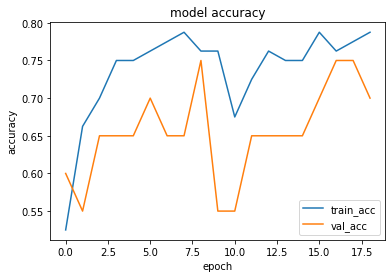

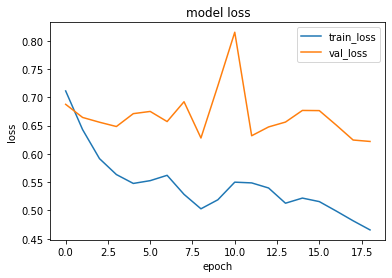

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
1it [00:00, 4476.31it/s]


prediction for video armflapping_1.mov is [[0.3192714]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.5585425]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.688088]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.16465768]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.14343077]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.157554]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 165ms/step - loss: 0.6972 - accuracy: 0.6000 - precision: 0.6111 - recall: 0.5500 - val_loss: 0.7421 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6295 - accuracy: 0.6875 - precision: 0.6744 - recall: 0.7250 - val_loss: 0.6832 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 160ms/step - loss: 0.5532 - accuracy: 0.7500 - precision: 0.7381 - recall: 0.7750 - val_loss: 0.7864 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6472 - accuracy: 0.7125 - precision: 0.6735 - recall: 0.8250 - val_loss: 0.8678 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5/7

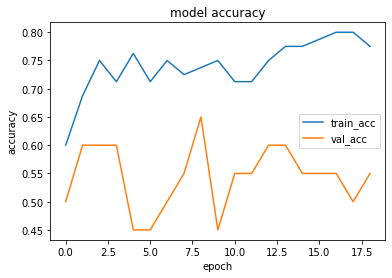

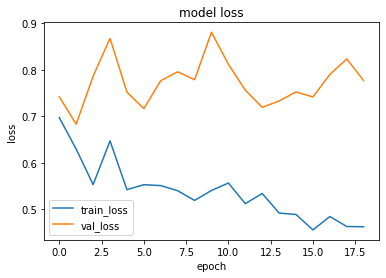

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.3633597]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.6488982]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.7254692]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.24863687]]


1it [00:00, 15420.24it/s]


prediction for video control_2.mov is [[0.21125683]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.21255314]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.7140 - accuracy: 0.5500 - precision: 0.5323 - recall: 0.8250 - val_loss: 0.5983 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6763 - accuracy: 0.5875 - precision: 0.6129 - recall: 0.4750 - val_loss: 0.6027 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6362 - accuracy: 0.6875 - precision: 0.6596 - recall: 0.7750 - val_loss: 0.5390 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5908 - accuracy: 0.7500 - precision: 0.7273 - recall: 0.8000 - val_loss: 0.5506 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5

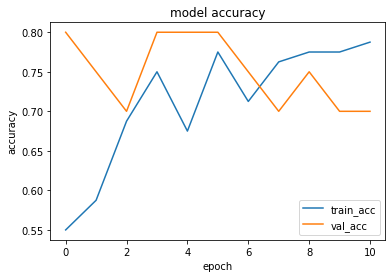

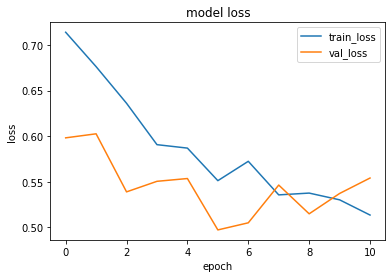

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5265825]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.4951354]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_2.mov is [[0.5659828]]


1it [00:00, 19972.88it/s]


prediction for video control_1.mov is [[0.49992883]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.4876787]]


1it [00:00, 13934.56it/s]


prediction for video control_3.mov is [[0.47939926]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6545 - accuracy: 0.6000 - precision: 0.5645 - recall: 0.8750 - val_loss: 0.7506 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.7006 - accuracy: 0.5625 - precision: 0.6923 - recall: 0.2250 - val_loss: 0.6603 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6086 - accuracy: 0.7125 - precision: 0.6735 - recall: 0.8250 - val_loss: 0.6455 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.5737 - accuracy: 0.7250 - precision: 0.6957 - recall: 0.8000 - val_loss: 0.7344 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000

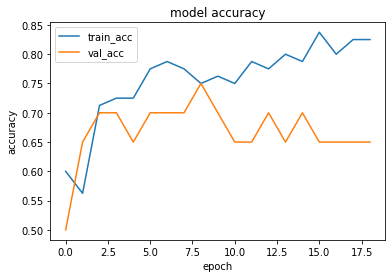

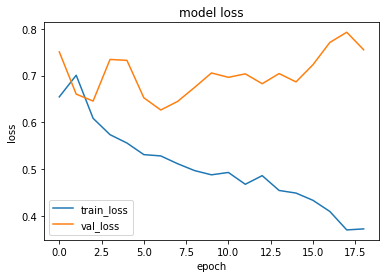

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.6511025]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.867183]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.8000183]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.5114102]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.44447824]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.31982717]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6964 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3750 - val_loss: 0.6488 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6831 - accuracy: 0.5875 - precision: 0.5556 - recall: 0.8750 - val_loss: 0.6572 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6310 - accuracy: 0.6875 - precision: 0.8571 - recall: 0.4500 - val_loss: 0.6215 - val_accuracy: 0.9000 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6254 - accuracy: 0.6500 - precision: 0.6154 - recall: 0.8000 - val_loss: 0.5974 - val_accuracy: 0.8500 - val_precision: 0.7692 - val_recall: 1.0000
Epoch 5

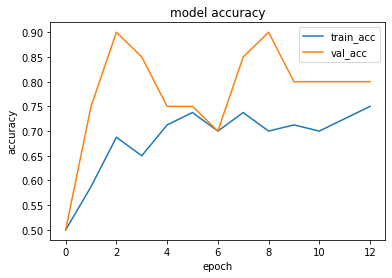

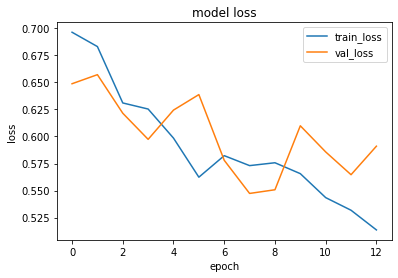

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.50615215]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.5230195]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.55697113]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.47714376]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.46358436]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.458053]]


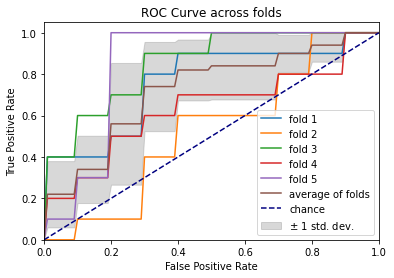

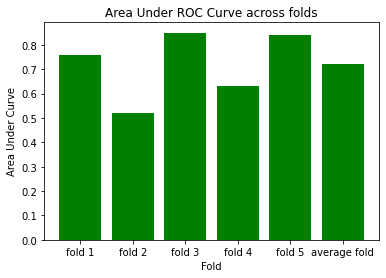

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6785 - accuracy: 0.5375 - precision: 0.5349 - recall: 0.5750 - val_loss: 0.8307 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 206ms/step - loss: 0.5956 - accuracy: 0.6875 - precision: 0.6596 - recall: 0.7750 - val_loss: 0.8576 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.5602 - accuracy: 0.7500 - precision: 0.7632 - recall: 0.7250 - val_loss: 0.8229 - val_accuracy: 0.5500 - val_precision: 0.5714 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.5278 - accuracy: 0.7500 - precision: 0.7632 - recall: 0.7250 - val_loss: 0.7889 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 148ms/s

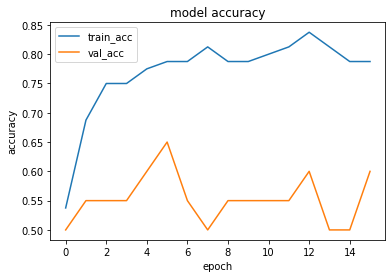

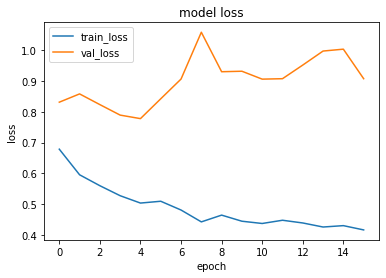

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.48230013]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.40746218]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5839306]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.37314704]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.30902028]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.2886578]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6740 - accuracy: 0.5250 - precision: 0.5185 - recall: 0.7000 - val_loss: 0.5374 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6490 - accuracy: 0.6500 - precision: 0.6154 - recall: 0.8000 - val_loss: 0.5861 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6672 - accuracy: 0.5625 - precision: 0.7273 - recall: 0.2000 - val_loss: 0.5629 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6135 - accuracy: 0.6875 - precision: 0.7027 - recall: 0.6500 - val_loss: 0.5630 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/

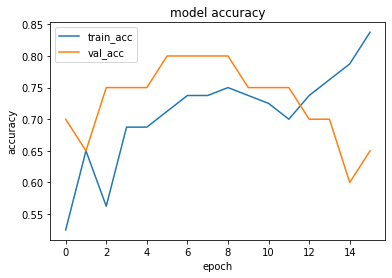

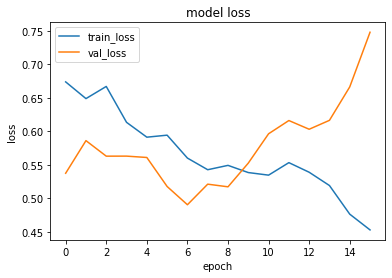

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.5931677]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.73537874]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.7344889]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.26951766]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.18416086]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.21380216]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.7842 - accuracy: 0.4250 - precision: 0.2857 - recall: 0.1000 - val_loss: 0.6840 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6686 - accuracy: 0.6875 - precision: 0.6829 - recall: 0.7000 - val_loss: 0.6692 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6455 - accuracy: 0.7000 - precision: 0.6600 - recall: 0.8250 - val_loss: 0.6315 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6438 - accuracy: 0.5875 - precision: 0.5854 - recall: 0.6000 - val_loss: 0.6235 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5

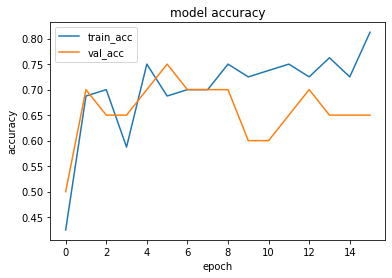

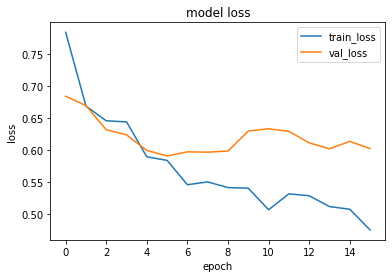

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.661528]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.6273485]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.72731906]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.3001375]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.28200424]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.2807843]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 158ms/step - loss: 0.6827 - accuracy: 0.5250 - precision: 0.5263 - recall: 0.5000 - val_loss: 0.7757 - val_accuracy: 0.4000 - val_precision: 0.4375 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 165ms/step - loss: 0.7061 - accuracy: 0.6250 - precision: 0.5833 - recall: 0.8750 - val_loss: 0.6884 - val_accuracy: 0.5500 - val_precision: 0.5556 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 172ms/step - loss: 0.6182 - accuracy: 0.7375 - precision: 0.7436 - recall: 0.7250 - val_loss: 0.6247 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 168ms/step - loss: 0.5987 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.5185 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5/

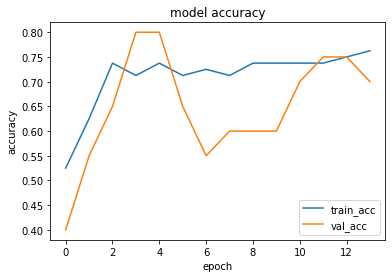

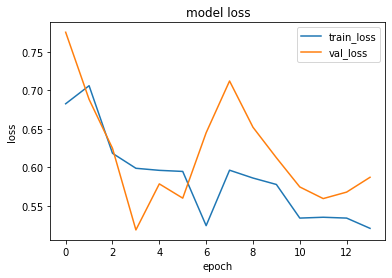

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.5588758]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.73147047]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.6654919]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.22076651]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.14832622]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.14676142]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.7121 - accuracy: 0.4500 - precision: 0.4615 - recall: 0.6000 - val_loss: 0.6824 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6686 - accuracy: 0.5875 - precision: 0.6522 - recall: 0.3750 - val_loss: 0.6383 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6369 - accuracy: 0.7000 - precision: 0.6818 - recall: 0.7500 - val_loss: 0.6158 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5901 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.8000 - val_loss: 0.5750 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5

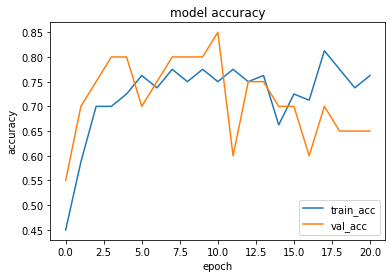

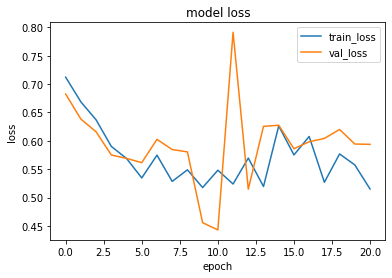

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.39229962]]


1it [00:00, 12633.45it/s]


prediction for video armflapping_3.mov is [[0.7376435]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.6868213]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.29624805]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.28551787]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.26771033]]


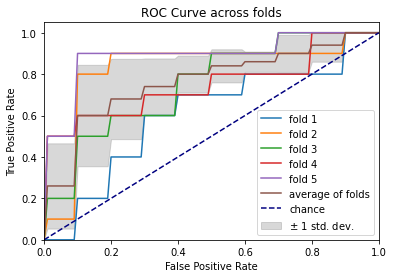

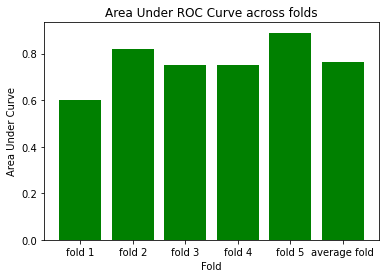

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6906 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5750 - val_loss: 0.6529 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.7013 - accuracy: 0.6000 - precision: 0.9000 - recall: 0.2250 - val_loss: 0.6709 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6301 - accuracy: 0.6750 - precision: 0.6522 - recall: 0.7500 - val_loss: 0.7109 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5925 - accuracy: 0.7000 - precision: 0.6538 - recall: 0.8500 - val_loss: 0.6597 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 146ms/s

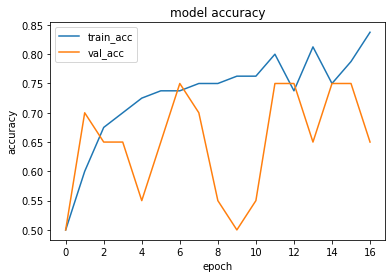

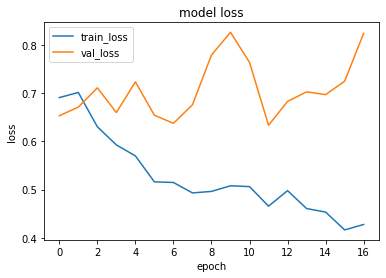

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.5193304]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.7291837]]


1it [00:00, 12157.40it/s]


prediction for video armflapping_2.mov is [[0.6855605]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.29882348]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.22940174]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.23902649]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.7493 - accuracy: 0.4750 - precision: 0.4500 - recall: 0.2250 - val_loss: 0.6577 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6770 - accuracy: 0.5125 - precision: 0.5063 - recall: 1.0000 - val_loss: 0.6461 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6608 - accuracy: 0.6375 - precision: 0.5821 - recall: 0.9750 - val_loss: 0.6152 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6465 - accuracy: 0.6750 - precision: 0.6842 - recall: 0.6500 - val_loss: 0.6145 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5

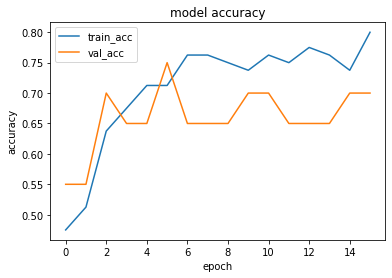

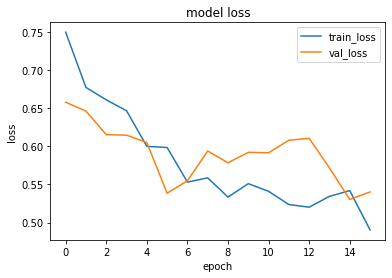

1it [00:00, 17772.47it/s]


prediction for video armflapping_1.mov is [[0.5736324]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.6683105]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.71918374]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.26098073]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.24127209]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.24244952]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 165ms/step - loss: 0.7156 - accuracy: 0.5250 - precision: 0.5227 - recall: 0.5750 - val_loss: 0.6647 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6602 - accuracy: 0.6125 - precision: 0.5882 - recall: 0.7500 - val_loss: 0.6608 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6190 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000 - val_loss: 0.6185 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.5890 - accuracy: 0.6875 - precision: 0.6667 - recall: 0.7500 - val_loss: 0.6177 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 5

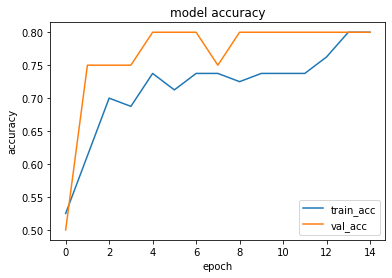

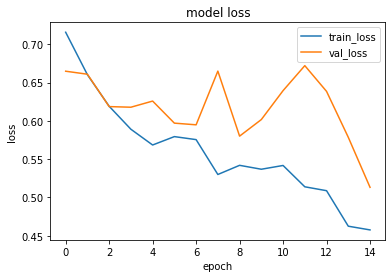

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.47998276]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.42471415]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.51478577]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.43242195]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.402031]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.39426777]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6930 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.7500 - val_loss: 0.6557 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6409 - accuracy: 0.6500 - precision: 0.6111 - recall: 0.8250 - val_loss: 0.5583 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6015 - accuracy: 0.7250 - precision: 0.7045 - recall: 0.7750 - val_loss: 0.5641 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6100 - accuracy: 0.6375 - precision: 0.6897 - recall: 0.5000 - val_loss: 0.6136 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5

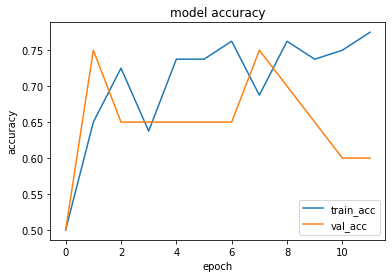

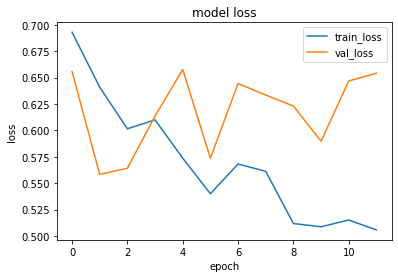

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.46864015]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.642432]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.6398415]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.21921736]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.14913005]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.14156774]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 187ms/step - loss: 0.6920 - accuracy: 0.5250 - precision: 0.5185 - recall: 0.7000 - val_loss: 0.6344 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6173 - accuracy: 0.7625 - precision: 0.7838 - recall: 0.7250 - val_loss: 0.5998 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.5935 - accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.6131 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.5633 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - val_loss: 0.6648 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5

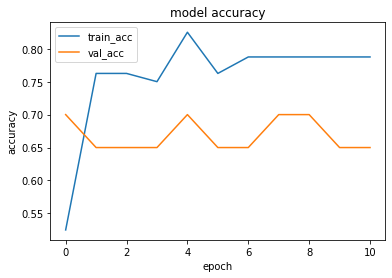

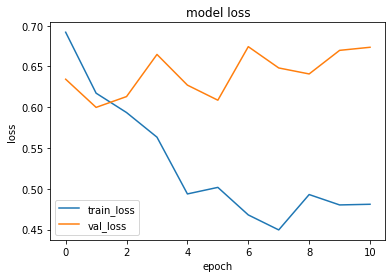

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.6321335]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.81655097]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.7927225]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.31489038]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.23079851]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.20902103]]


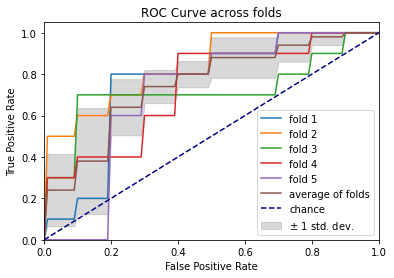

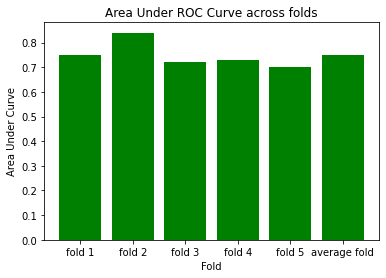

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.7033 - accuracy: 0.4875 - precision: 0.4783 - recall: 0.2750 - val_loss: 0.7129 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6319 - accuracy: 0.5875 - precision: 0.5522 - recall: 0.9250 - val_loss: 0.7459 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6156 - accuracy: 0.7250 - precision: 0.7500 - recall: 0.6750 - val_loss: 0.6606 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5677 - accuracy: 0.7250 - precision: 0.7143 - recall: 0.7500 - val_loss: 0.5926 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 149ms/s

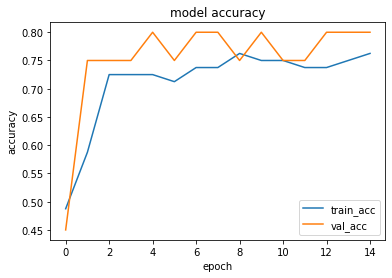

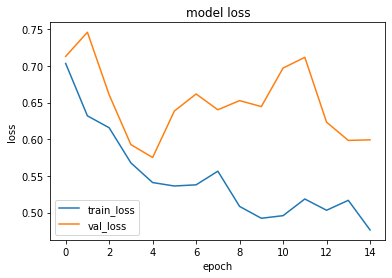

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.3156954]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.46709663]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.6095592]]


1it [00:00, 12483.05it/s]


prediction for video control_1.mov is [[0.19605279]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.17216676]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.16985512]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.7135 - accuracy: 0.4750 - precision: 0.4737 - recall: 0.4500 - val_loss: 0.6340 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6425 - accuracy: 0.6625 - precision: 0.6182 - recall: 0.8500 - val_loss: 0.6586 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6364 - accuracy: 0.7125 - precision: 0.8400 - recall: 0.5250 - val_loss: 0.5896 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 213ms/step - loss: 0.5789 - accuracy: 0.7375 - precision: 0.7111 - recall: 0.8000 - val_loss: 0.5393 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5

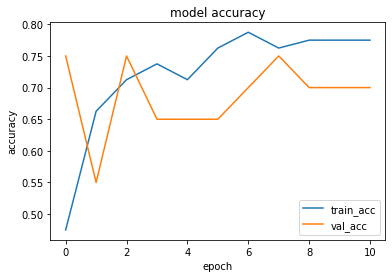

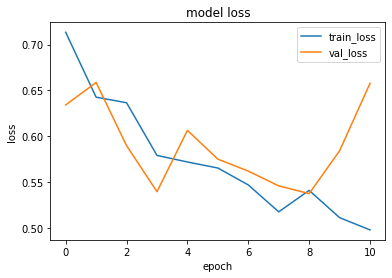

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.41646552]]


1it [00:00, 12372.58it/s]


prediction for video armflapping_3.mov is [[0.51611096]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.66423]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.2608863]]


1it [00:00, 11335.96it/s]


prediction for video control_2.mov is [[0.22925496]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.23864484]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.7002 - accuracy: 0.5125 - precision: 0.5161 - recall: 0.4000 - val_loss: 0.6231 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6356 - accuracy: 0.6625 - precision: 0.6226 - recall: 0.8250 - val_loss: 0.5847 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6404 - accuracy: 0.6375 - precision: 0.6038 - recall: 0.8000 - val_loss: 0.5768 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6100 - accuracy: 0.7125 - precision: 0.7073 - recall: 0.7250 - val_loss: 0.6138 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5

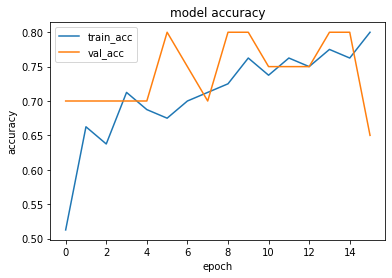

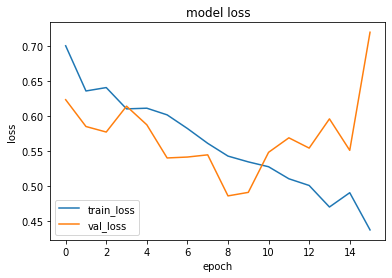

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.19395062]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.8734555]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.42783892]]


1it [00:00, 2519.10it/s]


prediction for video control_1.mov is [[0.29082078]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.34444314]]


1it [00:00, 13443.28it/s]


prediction for video control_3.mov is [[0.2214087]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6840 - accuracy: 0.5625 - precision: 0.5532 - recall: 0.6500 - val_loss: 0.7407 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7134 - accuracy: 0.6375 - precision: 0.6000 - recall: 0.8250 - val_loss: 0.6553 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6323 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000 - val_loss: 0.6248 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6022 - accuracy: 0.6500 - precision: 0.6304 - recall: 0.7250 - val_loss: 0.6483 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/

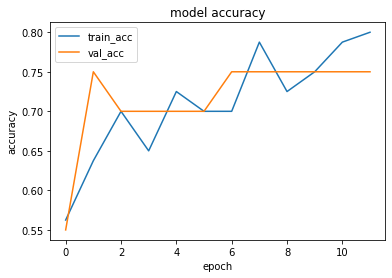

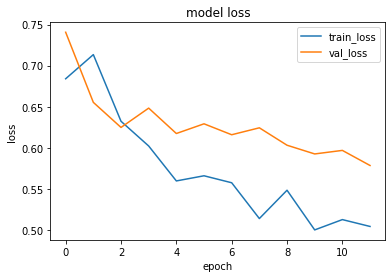

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.6105628]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.54636014]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.6485291]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.24509609]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.20458058]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.19023347]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6988 - accuracy: 0.5250 - precision: 0.5147 - recall: 0.8750 - val_loss: 0.6612 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6603 - accuracy: 0.6000 - precision: 0.5588 - recall: 0.9500 - val_loss: 0.6121 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6119 - accuracy: 0.7000 - precision: 0.7500 - recall: 0.6000 - val_loss: 0.5867 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6009 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - val_loss: 0.6633 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5

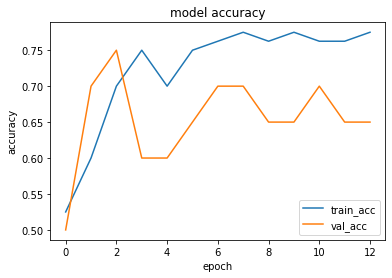

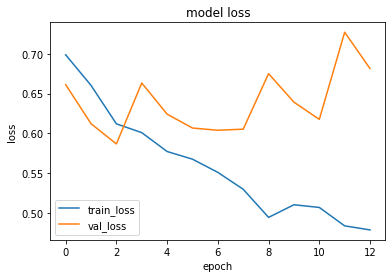

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.7890798]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.89563096]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.8479285]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.17775387]]


1it [00:00, 13842.59it/s]


prediction for video control_2.mov is [[0.17296955]]


1it [00:00, 18315.74it/s]


prediction for video control_3.mov is [[0.19534034]]


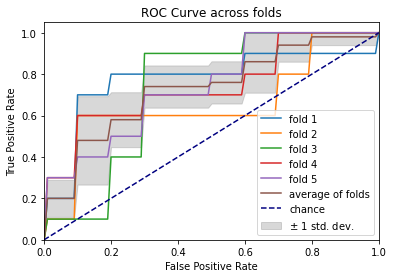

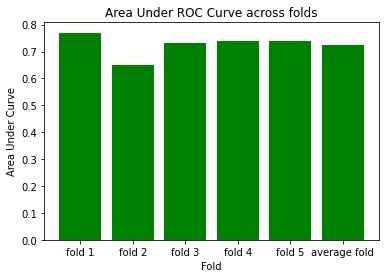

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6849 - accuracy: 0.5750 - precision: 0.5789 - recall: 0.5500 - val_loss: 0.6165 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6625 - accuracy: 0.6875 - precision: 0.6471 - recall: 0.8250 - val_loss: 0.5655 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6655 - accuracy: 0.6625 - precision: 0.6444 - recall: 0.7250 - val_loss: 0.5899 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6170 - accuracy: 0.7125 - precision: 0.7931 - recall: 0.5750 - val_loss: 0.6166 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 5/75
3/3 [==============================] - 0s 128ms/s

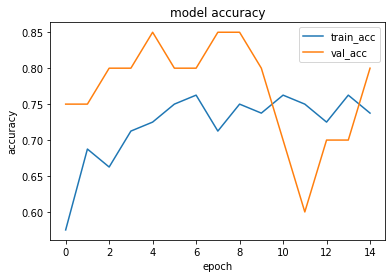

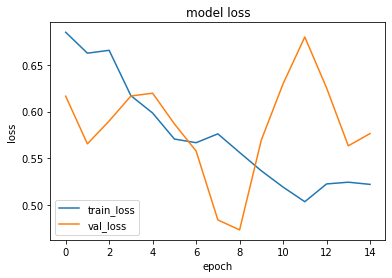

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.479438]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.4937762]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.54767156]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.41812328]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.37907115]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.3590109]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6674 - accuracy: 0.5625 - precision: 0.6471 - recall: 0.2750 - val_loss: 0.7489 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6644 - accuracy: 0.6375 - precision: 0.5846 - recall: 0.9500 - val_loss: 0.6394 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6191 - accuracy: 0.7125 - precision: 0.8400 - recall: 0.5250 - val_loss: 0.6747 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6061 - accuracy: 0.7000 - precision: 0.6905 - recall: 0.7250 - val_loss: 0.7107 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5/

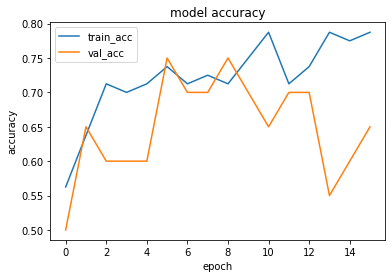

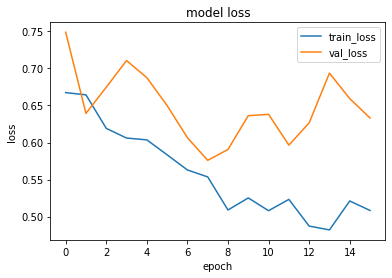

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.2769766]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.5957974]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.6420998]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.1782529]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.16763458]]


1it [00:00, 15196.75it/s]


prediction for video control_3.mov is [[0.16693038]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6663 - accuracy: 0.4875 - precision: 0.4915 - recall: 0.7250 - val_loss: 0.8075 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6109 - accuracy: 0.6375 - precision: 0.6279 - recall: 0.6750 - val_loss: 0.9148 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6059 - accuracy: 0.6750 - precision: 0.6296 - recall: 0.8500 - val_loss: 0.8386 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.5922 - accuracy: 0.7500 - precision: 0.7941 - recall: 0.6750 - val_loss: 0.7796 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 5

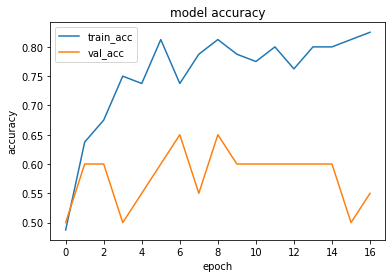

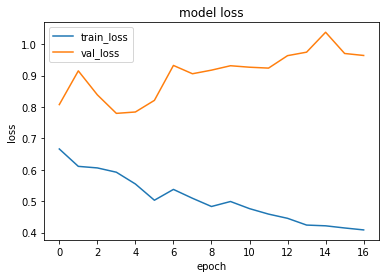

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.5579897]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.36547086]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.77270603]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.3159485]]


1it [00:00, 15420.24it/s]


prediction for video control_2.mov is [[0.21875826]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.20698369]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6998 - accuracy: 0.4750 - precision: 0.4643 - recall: 0.3250 - val_loss: 0.6240 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6662 - accuracy: 0.5500 - precision: 0.5286 - recall: 0.9250 - val_loss: 0.5845 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 145ms/step - loss: 0.7102 - accuracy: 0.6500 - precision: 0.6200 - recall: 0.7750 - val_loss: 0.5844 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6224 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.5905 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5

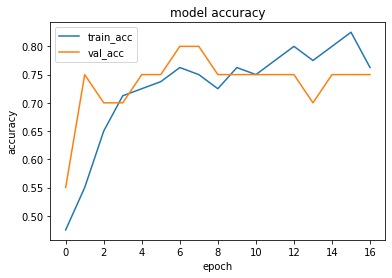

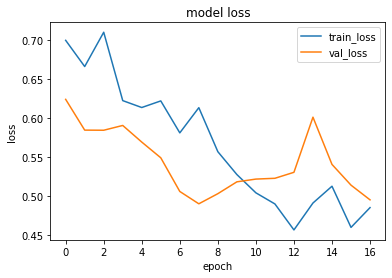

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.58077455]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.81768113]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.72934175]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.37083155]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.29135638]]


1it [00:00, 15768.06it/s]


prediction for video control_3.mov is [[0.25027198]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6765 - accuracy: 0.6375 - precision: 0.6486 - recall: 0.6000 - val_loss: 0.7097 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6684 - accuracy: 0.6000 - precision: 0.6538 - recall: 0.4250 - val_loss: 0.6280 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6777 - accuracy: 0.6125 - precision: 0.5692 - recall: 0.9250 - val_loss: 0.6039 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6277 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.5803 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000

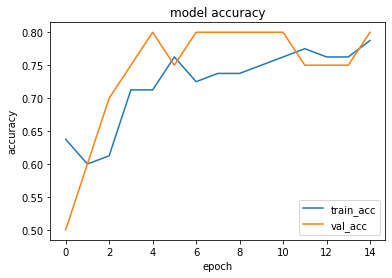

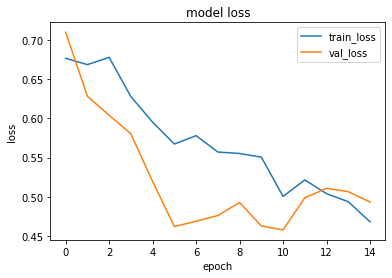

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.44445923]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.903247]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.8805751]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.3361253]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.25221068]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.27124566]]


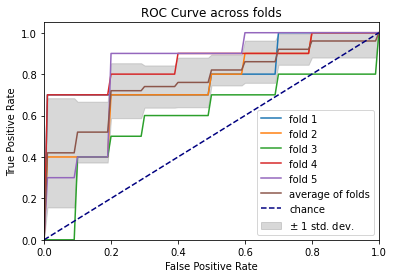

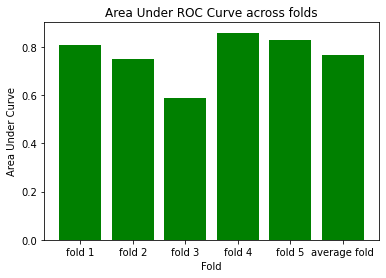

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6799 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.7750 - val_loss: 0.6509 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6751 - accuracy: 0.6000 - precision: 0.7500 - recall: 0.3000 - val_loss: 0.6060 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6395 - accuracy: 0.7125 - precision: 0.6667 - recall: 0.8500 - val_loss: 0.5823 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6002 - accuracy: 0.7375 - precision: 0.7021 - recall: 0.8250 - val_loss: 0.5795 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 152ms/s

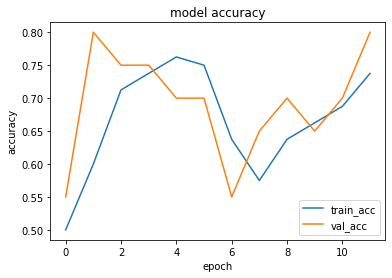

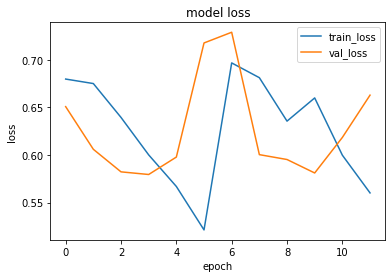

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.5017622]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.5098254]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.52773356]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.4854696]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.48066932]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.4792056]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6781 - accuracy: 0.5250 - precision: 0.5167 - recall: 0.7750 - val_loss: 0.5659 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6493 - accuracy: 0.5625 - precision: 0.5362 - recall: 0.9250 - val_loss: 0.5940 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6134 - accuracy: 0.7250 - precision: 0.8000 - recall: 0.6000 - val_loss: 0.5820 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6391 - accuracy: 0.6875 - precision: 0.6829 - recall: 0.7000 - val_loss: 0.5542 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 5/

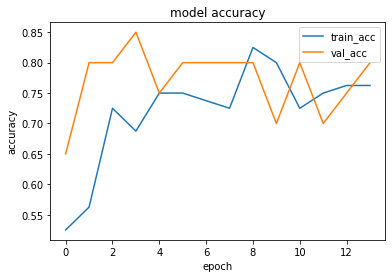

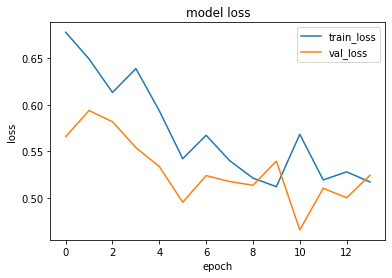

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5070582]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.62383175]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.54765177]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.46277925]]


1it [00:00, 12336.19it/s]


prediction for video control_2.mov is [[0.44431433]]


1it [00:00, 13025.79it/s]


prediction for video control_3.mov is [[0.4394663]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6627 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.6000 - val_loss: 0.6585 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.5821 - accuracy: 0.7125 - precision: 0.7073 - recall: 0.7250 - val_loss: 0.6913 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.5514 - accuracy: 0.7750 - precision: 0.7895 - recall: 0.7500 - val_loss: 0.6919 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.5448 - accuracy: 0.7625 - precision: 0.8621 - recall: 0.6250 - val_loss: 0.8446 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 5/

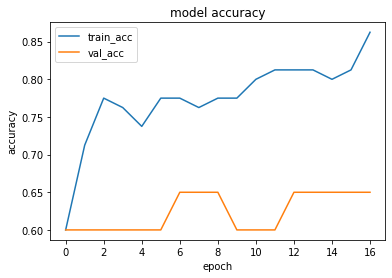

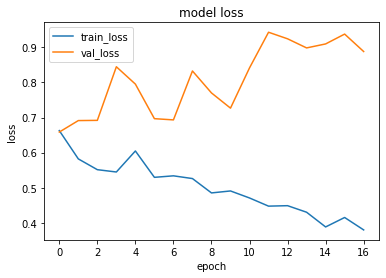

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.80616766]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.8602561]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.8816555]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.21236125]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.25699615]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.29712325]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 216ms/step - loss: 0.6700 - accuracy: 0.5750 - precision: 0.5833 - recall: 0.5250 - val_loss: 0.6529 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.5949 - accuracy: 0.7500 - precision: 0.7381 - recall: 0.7750 - val_loss: 0.6408 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6324 - accuracy: 0.6500 - precision: 0.7727 - recall: 0.4250 - val_loss: 0.6522 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5709 - accuracy: 0.7250 - precision: 0.7812 - recall: 0.6250 - val_loss: 0.6495 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5

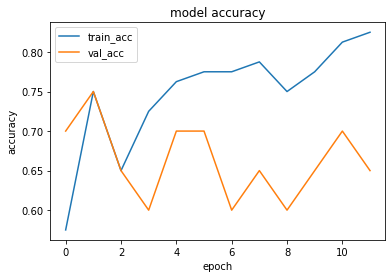

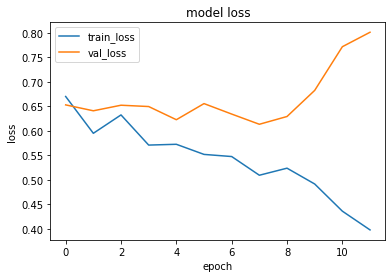

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.3052631]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.9413196]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.8186497]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.3236083]]


1it [00:00, 16448.25it/s]


prediction for video control_2.mov is [[0.2737865]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.29804945]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.7750 - accuracy: 0.4375 - precision: 0.3913 - recall: 0.2250 - val_loss: 0.6655 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6507 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.6382 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6444 - accuracy: 0.5750 - precision: 0.5417 - recall: 0.9750 - val_loss: 0.6381 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6327 - accuracy: 0.7000 - precision: 0.7667 - recall: 0.5750 - val_loss: 0.6853 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 5

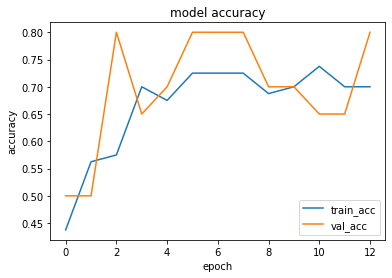

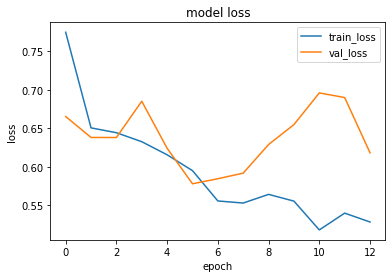

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.5012299]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.511202]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.59459674]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.426291]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.38031605]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.35474283]]


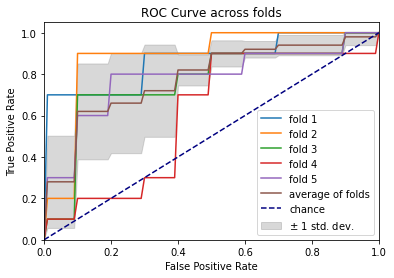

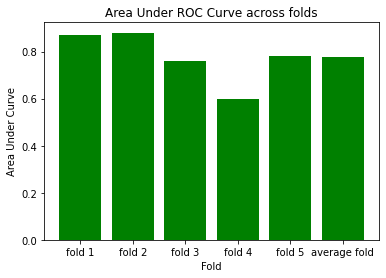

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6778 - accuracy: 0.5125 - precision: 0.5106 - recall: 0.6000 - val_loss: 0.8899 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6984 - accuracy: 0.6375 - precision: 0.5965 - recall: 0.8500 - val_loss: 0.7730 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6253 - accuracy: 0.6750 - precision: 0.7500 - recall: 0.5250 - val_loss: 0.6996 - val_accuracy: 0.5500 - val_precision: 0.5714 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.5926 - accuracy: 0.7375 - precision: 0.7879 - recall: 0.6500 - val_loss: 0.6715 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 156ms/s

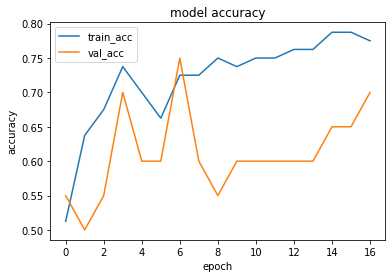

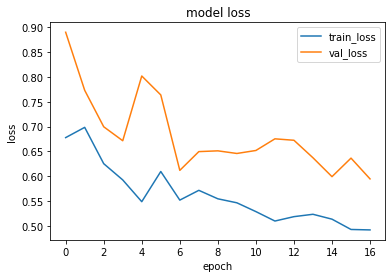

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.48639315]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5238816]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.5917405]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.41689998]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.38443327]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.3839599]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 221ms/step - loss: 0.6744 - accuracy: 0.4625 - precision: 0.4706 - recall: 0.6000 - val_loss: 0.6402 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6036 - accuracy: 0.7375 - precision: 0.7436 - recall: 0.7250 - val_loss: 0.6434 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 156ms/step - loss: 0.5550 - accuracy: 0.7375 - precision: 0.7209 - recall: 0.7750 - val_loss: 0.7758 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 178ms/step - loss: 0.5347 - accuracy: 0.7625 - precision: 0.7692 - recall: 0.7500 - val_loss: 0.6780 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/

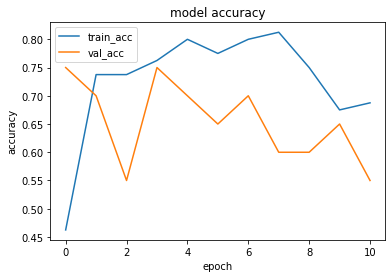

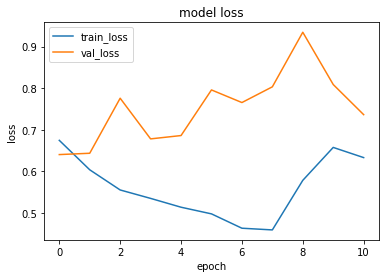

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.36552376]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.4588629]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.42316929]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.3372525]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.31028426]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.3191714]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6649 - accuracy: 0.5375 - precision: 0.5246 - recall: 0.8000 - val_loss: 0.7040 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.7337 - accuracy: 0.5500 - precision: 0.5278 - recall: 0.9500 - val_loss: 0.6222 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6535 - accuracy: 0.6625 - precision: 0.6970 - recall: 0.5750 - val_loss: 0.6100 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6121 - accuracy: 0.6750 - precision: 0.7059 - recall: 0.6000 - val_loss: 0.5706 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5/

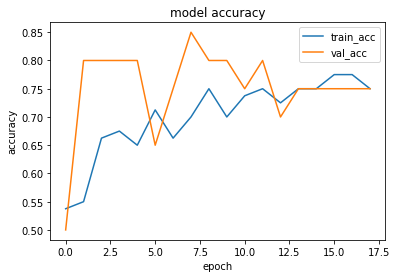

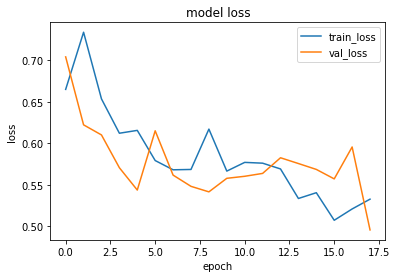

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.4812043]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.46164626]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5405958]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.38096386]]


1it [00:00, 12671.61it/s]


prediction for video control_2.mov is [[0.31822962]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.26454735]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7143 - accuracy: 0.5125 - precision: 0.5116 - recall: 0.5500 - val_loss: 0.6355 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6705 - accuracy: 0.6125 - precision: 0.5672 - recall: 0.9500 - val_loss: 0.6557 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6295 - accuracy: 0.6625 - precision: 0.6970 - recall: 0.5750 - val_loss: 0.5818 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.5898 - accuracy: 0.7250 - precision: 0.6875 - recall: 0.8250 - val_loss: 0.5018 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5

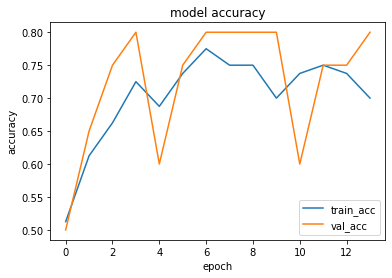

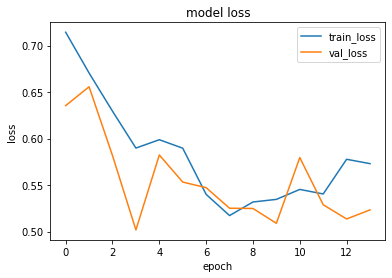

1it [00:00, 11491.24it/s]


prediction for video armflapping_1.mov is [[0.442171]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.47865468]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.61712027]]


1it [00:00, 14217.98it/s]


prediction for video control_1.mov is [[0.31072646]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.23105362]]


1it [00:00, 12336.19it/s]


prediction for video control_3.mov is [[0.20396757]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6754 - accuracy: 0.5250 - precision: 0.5217 - recall: 0.6000 - val_loss: 0.6671 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6037 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.6940 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6225 - accuracy: 0.6875 - precision: 0.7419 - recall: 0.5750 - val_loss: 0.6876 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5759 - accuracy: 0.7625 - precision: 0.7692 - recall: 0.7500 - val_loss: 0.6988 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5

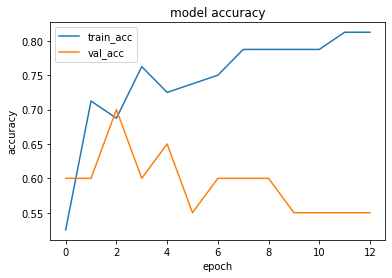

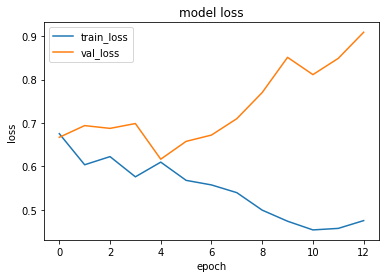

1it [00:00, 14563.56it/s]


prediction for video armflapping_1.mov is [[0.64240664]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.40112805]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.77549267]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.49825642]]


1it [00:00, 14217.98it/s]


prediction for video control_2.mov is [[0.28786826]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.32410702]]


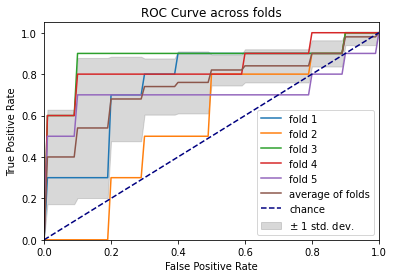

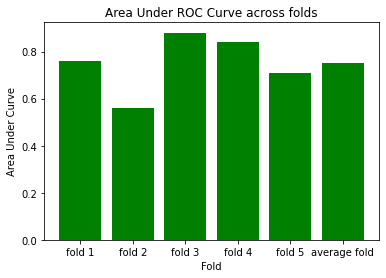

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6766 - accuracy: 0.5125 - precision: 0.5161 - recall: 0.4000 - val_loss: 0.6786 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.7262 - accuracy: 0.5750 - precision: 0.5455 - recall: 0.9000 - val_loss: 0.6689 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5902 - accuracy: 0.7750 - precision: 0.8438 - recall: 0.6750 - val_loss: 0.9742 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.5531 - accuracy: 0.7750 - precision: 0.8056 - recall: 0.7250 - val_loss: 0.6284 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s

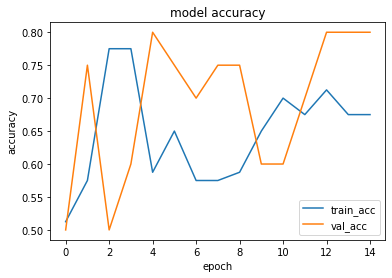

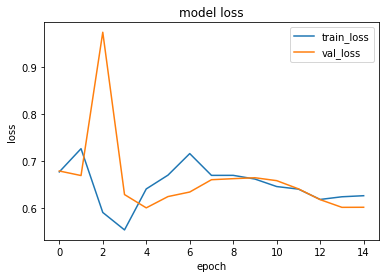

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.58672315]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_3.mov is [[0.6807091]]


1it [00:00, 13617.87it/s]


prediction for video armflapping_2.mov is [[0.6898049]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.10288596]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.10176301]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.14951298]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6795 - accuracy: 0.6000 - precision: 0.5741 - recall: 0.7750 - val_loss: 0.6559 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6131 - accuracy: 0.7000 - precision: 0.6538 - recall: 0.8500 - val_loss: 0.6456 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.7228 - accuracy: 0.6000 - precision: 0.7857 - recall: 0.2750 - val_loss: 0.6346 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.5801 - accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.7005 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5

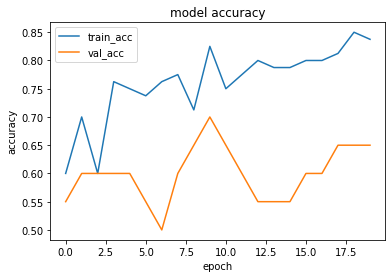

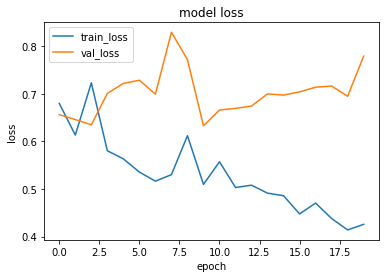

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.56798303]]


1it [00:00, 9000.65it/s]


prediction for video armflapping_3.mov is [[0.4476524]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.8930397]]


1it [00:00, 16320.25it/s]


prediction for video control_1.mov is [[0.2348578]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.20985392]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.20463026]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6760 - accuracy: 0.6250 - precision: 0.5862 - recall: 0.8500 - val_loss: 0.6613 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.7657 - accuracy: 0.6250 - precision: 0.5962 - recall: 0.7750 - val_loss: 0.6770 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5939 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000 - val_loss: 0.6581 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5916 - accuracy: 0.7375 - precision: 0.7714 - recall: 0.6750 - val_loss: 0.6494 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5

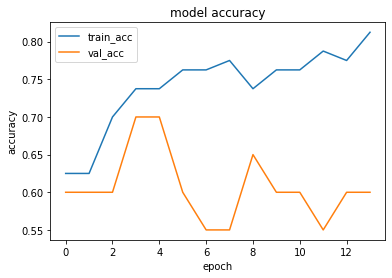

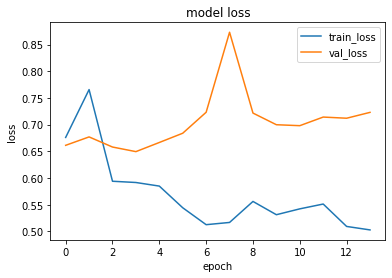

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.65042067]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.6439933]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.7405091]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.45379803]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.36271113]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.35063004]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7049 - accuracy: 0.4375 - precision: 0.4286 - recall: 0.3750 - val_loss: 0.6780 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6594 - accuracy: 0.7000 - precision: 0.6481 - recall: 0.8750 - val_loss: 0.6378 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6631 - accuracy: 0.5875 - precision: 0.6522 - recall: 0.3750 - val_loss: 0.6070 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5939 - accuracy: 0.6625 - precision: 0.6757 - recall: 0.6250 - val_loss: 0.6000 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5

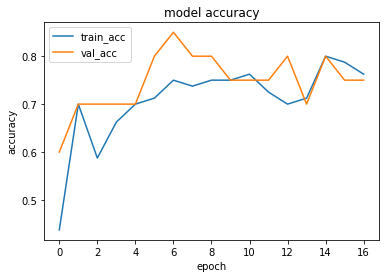

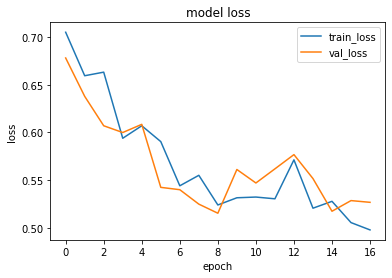

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.51578707]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.591101]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.60599273]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.3484373]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.27968323]]


1it [00:00, 15087.42it/s]


prediction for video control_3.mov is [[0.24301809]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7257 - accuracy: 0.3750 - precision: 0.2917 - recall: 0.1750 - val_loss: 0.6626 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6836 - accuracy: 0.5125 - precision: 0.5075 - recall: 0.8500 - val_loss: 0.6397 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6740 - accuracy: 0.6375 - precision: 0.5965 - recall: 0.8500 - val_loss: 0.5850 - val_accuracy: 0.8500 - val_precision: 0.8182 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6472 - accuracy: 0.6375 - precision: 0.6410 - recall: 0.6250 - val_loss: 0.4869 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5

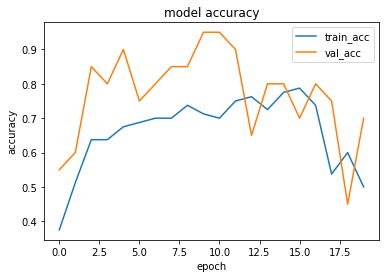

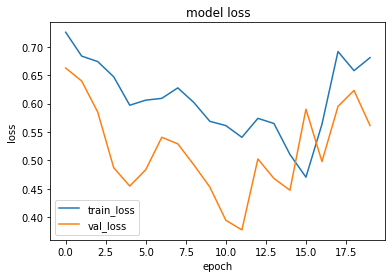

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.6020882]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.61750996]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.6934909]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.4898378]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.4514468]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.43017265]]


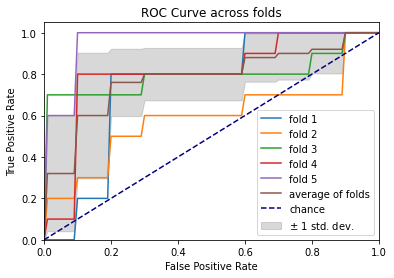

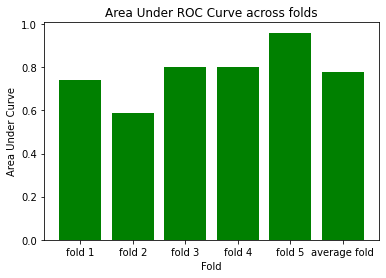

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7565 - accuracy: 0.4000 - precision: 0.4130 - recall: 0.4750 - val_loss: 0.6706 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6791 - accuracy: 0.6125 - precision: 0.6098 - recall: 0.6250 - val_loss: 0.6127 - val_accuracy: 0.8500 - val_precision: 0.7692 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6606 - accuracy: 0.6375 - precision: 0.6078 - recall: 0.7750 - val_loss: 0.5203 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6445 - accuracy: 0.6125 - precision: 0.5849 - recall: 0.7750 - val_loss: 0.4611 - val_accuracy: 0.9500 - val_precision: 0.9091 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 125ms/s

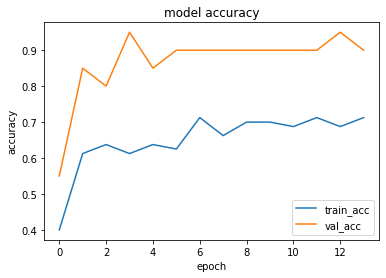

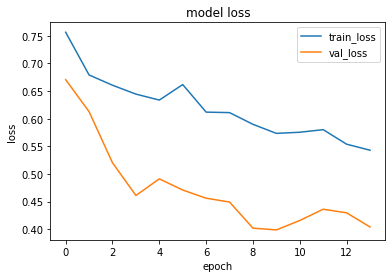

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.49797702]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.49851033]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.5654885]]


1it [00:00, 13934.56it/s]


prediction for video control_1.mov is [[0.44921198]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.4252276]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.40904674]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7198 - accuracy: 0.4750 - precision: 0.4643 - recall: 0.3250 - val_loss: 0.6845 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6592 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.6864 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6388 - accuracy: 0.6875 - precision: 0.6667 - recall: 0.7500 - val_loss: 0.7537 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.5840 - accuracy: 0.7375 - precision: 0.6939 - recall: 0.8500 - val_loss: 0.7143 - val_accuracy: 0.5500 - val_precision: 0.5556 - val_recall: 0.5000
Epoch 5

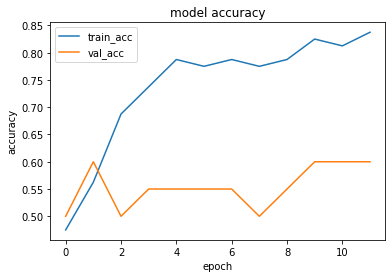

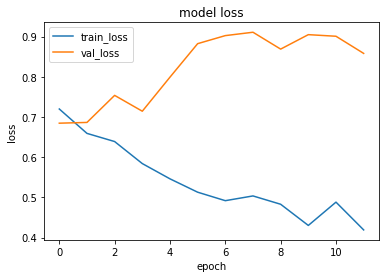

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.3570686]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.6105328]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.6961674]]


1it [00:00, 13357.66it/s]


prediction for video control_1.mov is [[0.41834527]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.23752859]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.3454028]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7259 - accuracy: 0.4750 - precision: 0.4545 - recall: 0.2500 - val_loss: 0.6842 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6715 - accuracy: 0.5250 - precision: 0.5128 - recall: 1.0000 - val_loss: 0.6792 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6412 - accuracy: 0.6250 - precision: 0.5833 - recall: 0.8750 - val_loss: 0.6734 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6073 - accuracy: 0.7125 - precision: 0.6735 - recall: 0.8250 - val_loss: 0.6565 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 5/

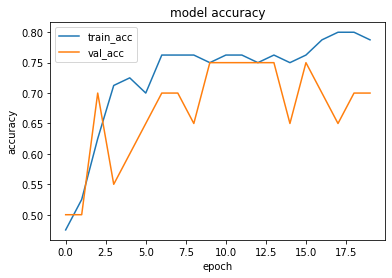

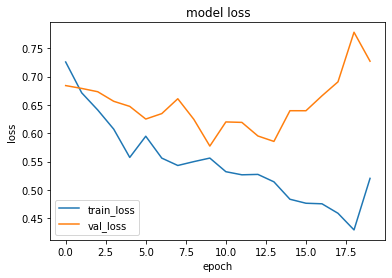

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.6405394]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.73632234]]


1it [00:00, 9915.61it/s]


prediction for video armflapping_2.mov is [[0.8842795]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.27096862]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.25664216]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.22203293]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7313 - accuracy: 0.4375 - precision: 0.4561 - recall: 0.6500 - val_loss: 0.6856 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6662 - accuracy: 0.6500 - precision: 0.7727 - recall: 0.4250 - val_loss: 0.6507 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6461 - accuracy: 0.6625 - precision: 0.6757 - recall: 0.6250 - val_loss: 0.6539 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5934 - accuracy: 0.7375 - precision: 0.7111 - recall: 0.8000 - val_loss: 0.6204 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5

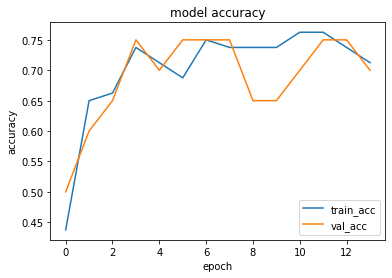

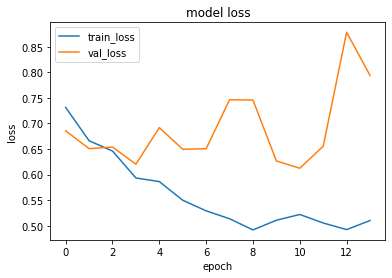

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.6306869]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.77383184]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.7374002]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.01754251]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.01693541]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.01667732]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7138 - accuracy: 0.4625 - precision: 0.4754 - recall: 0.7250 - val_loss: 0.6030 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6689 - accuracy: 0.5875 - precision: 0.5556 - recall: 0.8750 - val_loss: 0.5846 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6560 - accuracy: 0.6875 - precision: 0.6829 - recall: 0.7000 - val_loss: 0.5555 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6181 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.5070 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5

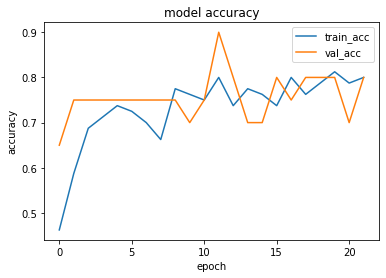

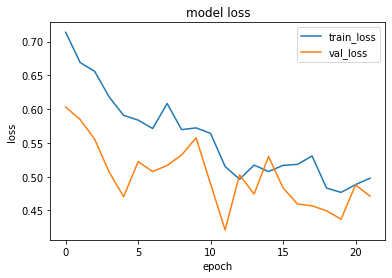

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.6221171]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.77213985]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.755903]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.24034187]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.20014477]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.1844028]]


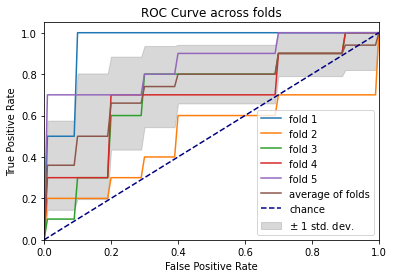

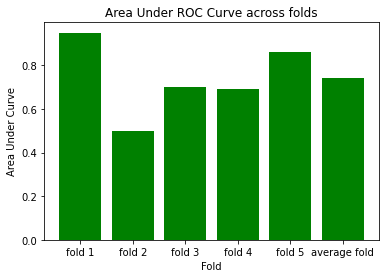

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6815 - accuracy: 0.6625 - precision: 0.6970 - recall: 0.5750 - val_loss: 0.6158 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6934 - accuracy: 0.5625 - precision: 0.5410 - recall: 0.8250 - val_loss: 0.6281 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6292 - accuracy: 0.6750 - precision: 0.6591 - recall: 0.7250 - val_loss: 0.5501 - val_accuracy: 0.8500 - val_precision: 0.8182 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.5994 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.8000 - val_loss: 0.4571 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 123ms/s

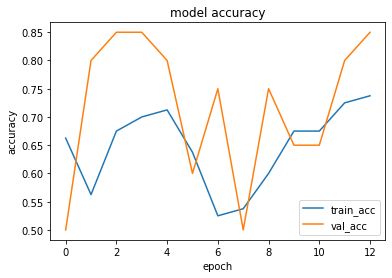

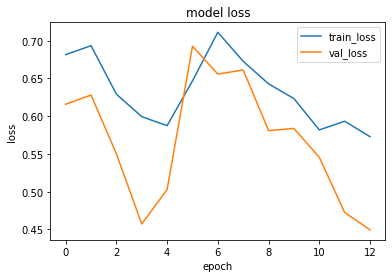

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5075553]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.50873846]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.6027398]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.45325553]]


1it [00:00, 13189.64it/s]


prediction for video control_2.mov is [[0.4294182]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.41437602]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6735 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.6250 - val_loss: 0.7456 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6277 - accuracy: 0.6750 - precision: 0.6129 - recall: 0.9500 - val_loss: 0.7354 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.5899 - accuracy: 0.7250 - precision: 0.7812 - recall: 0.6250 - val_loss: 0.7050 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 1s 192ms/step - loss: 0.5700 - accuracy: 0.7250 - precision: 0.7812 - recall: 0.6250 - val_loss: 0.6125 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5

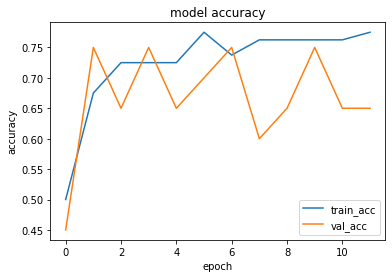

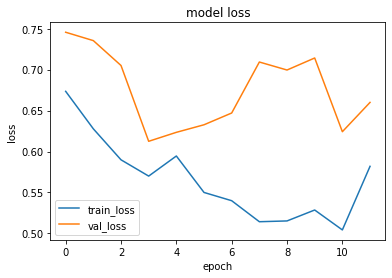

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.30232865]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.7750706]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.7626091]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.15893885]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.14935586]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.1281408]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6929 - accuracy: 0.5625 - precision: 0.5472 - recall: 0.7250 - val_loss: 0.6906 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6261 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - val_loss: 0.8917 - val_accuracy: 0.4500 - val_precision: 0.4667 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6062 - accuracy: 0.7250 - precision: 0.7045 - recall: 0.7750 - val_loss: 0.8749 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5728 - accuracy: 0.7875 - precision: 0.7949 - recall: 0.7750 - val_loss: 0.8905 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5/

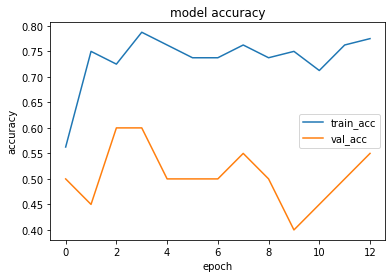

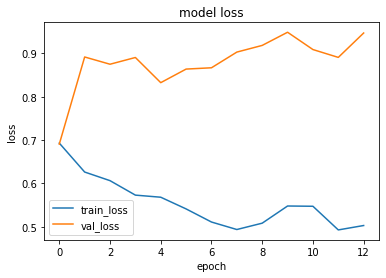

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.50076413]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.7329]]


1it [00:00, 12865.96it/s]


prediction for video armflapping_2.mov is [[0.7638815]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.20977038]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.18921924]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.18420142]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6979 - accuracy: 0.4250 - precision: 0.4444 - recall: 0.6000 - val_loss: 0.6204 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6374 - accuracy: 0.7375 - precision: 0.7111 - recall: 0.8000 - val_loss: 0.5611 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5958 - accuracy: 0.7000 - precision: 0.6600 - recall: 0.8250 - val_loss: 0.9286 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6123 - accuracy: 0.7125 - precision: 0.8400 - recall: 0.5250 - val_loss: 0.6368 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5

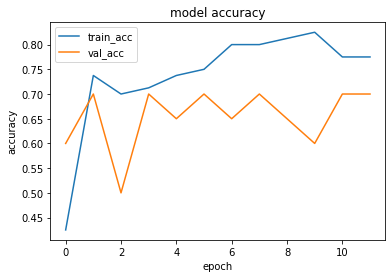

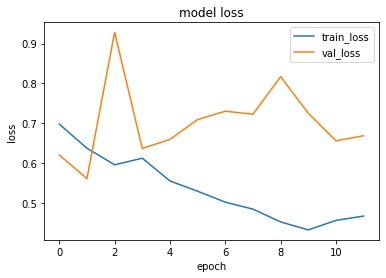

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.38856518]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.60355985]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.5395932]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.26979837]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.22574297]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.21913105]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7273 - accuracy: 0.4500 - precision: 0.4231 - recall: 0.2750 - val_loss: 0.6514 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6598 - accuracy: 0.5500 - precision: 0.5303 - recall: 0.8750 - val_loss: 0.6403 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6583 - accuracy: 0.6125 - precision: 0.5714 - recall: 0.9000 - val_loss: 0.6273 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6193 - accuracy: 0.7125 - precision: 0.8148 - recall: 0.5500 - val_loss: 0.6456 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5

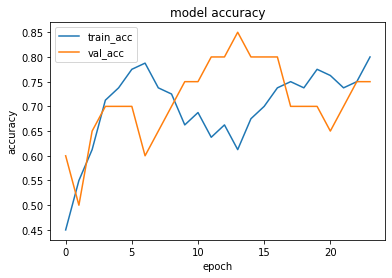

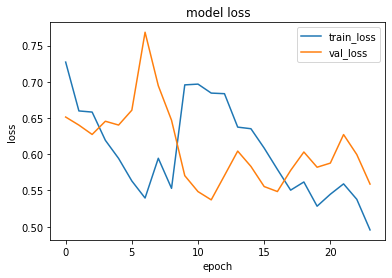

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.6153955]]


1it [00:00, 12483.05it/s]


prediction for video armflapping_3.mov is [[0.50346684]]


1it [00:00, 12157.40it/s]


prediction for video armflapping_2.mov is [[0.7888305]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.38272393]]


1it [00:00, 13357.66it/s]


prediction for video control_2.mov is [[0.27825314]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.28528744]]


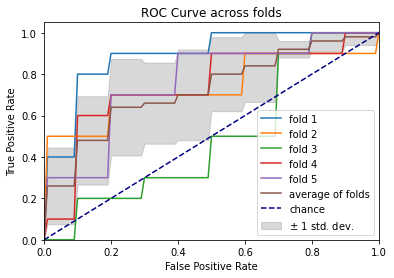

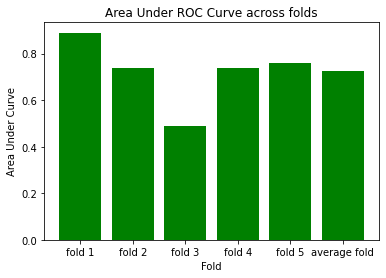

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.7717 - accuracy: 0.3375 - precision: 0.2903 - recall: 0.2250 - val_loss: 0.6910 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6919 - accuracy: 0.5625 - precision: 0.5424 - recall: 0.8000 - val_loss: 0.6826 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6530 - accuracy: 0.5750 - precision: 0.5417 - recall: 0.9750 - val_loss: 0.6523 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6254 - accuracy: 0.6750 - precision: 0.6346 - recall: 0.8250 - val_loss: 0.6189 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 134ms/s

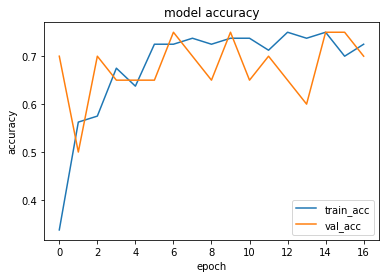

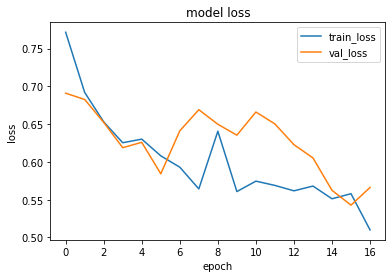

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.50891775]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.55079293]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.58485246]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.40660703]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.37083715]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.31434324]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.7003 - accuracy: 0.4875 - precision: 0.4902 - recall: 0.6250 - val_loss: 0.6376 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6846 - accuracy: 0.5750 - precision: 0.5517 - recall: 0.8000 - val_loss: 0.6332 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6386 - accuracy: 0.6750 - precision: 0.6750 - recall: 0.6750 - val_loss: 0.5706 - val_accuracy: 0.9000 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6319 - accuracy: 0.6875 - precision: 0.6667 - recall: 0.7500 - val_loss: 0.4959 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5

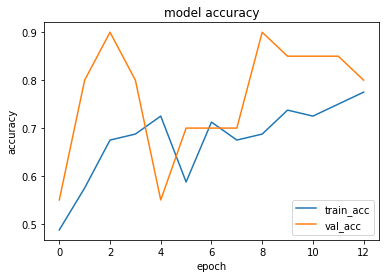

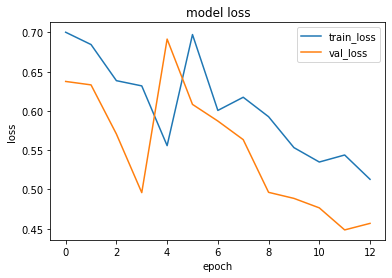

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.50692517]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.5230466]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.5764589]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.46486107]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.43414742]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.43230742]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7016 - accuracy: 0.4625 - precision: 0.4737 - recall: 0.6750 - val_loss: 0.7967 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.7465 - accuracy: 0.4500 - precision: 0.4167 - recall: 0.2500 - val_loss: 0.6198 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6593 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.6071 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6362 - accuracy: 0.6500 - precision: 0.6304 - recall: 0.7250 - val_loss: 0.5957 - val_accuracy: 0.8500 - val_precision: 0.8182 - val_recall: 0.9000

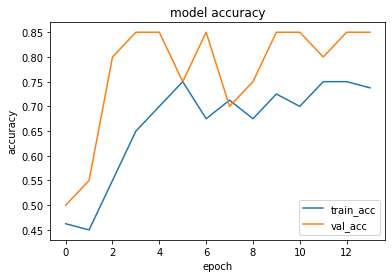

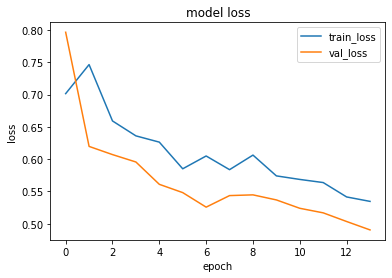

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.52559084]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.4242542]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.6412526]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.40790933]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.24713221]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.28112325]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6957 - accuracy: 0.5625 - precision: 0.5490 - recall: 0.7000 - val_loss: 0.7334 - val_accuracy: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6639 - accuracy: 0.5875 - precision: 0.6667 - recall: 0.3500 - val_loss: 0.6888 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6244 - accuracy: 0.7125 - precision: 0.6604 - recall: 0.8750 - val_loss: 0.6390 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6046 - accuracy: 0.7375 - precision: 0.7111 - recall: 0.8000 - val_loss: 0.6654 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5

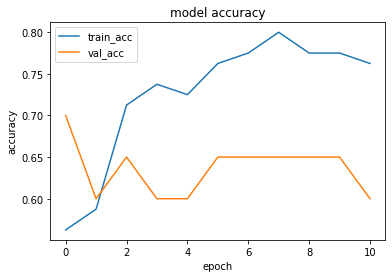

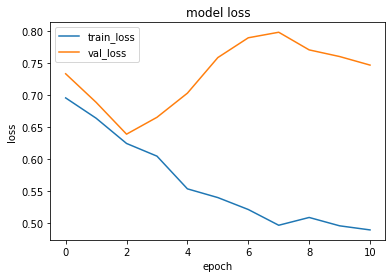

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.60842294]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.7129492]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.786899]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.34715563]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.26650673]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.26555508]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6770 - accuracy: 0.5750 - precision: 0.6500 - recall: 0.3250 - val_loss: 0.7721 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5933 - accuracy: 0.7500 - precision: 0.7083 - recall: 0.8500 - val_loss: 0.7277 - val_accuracy: 0.5500 - val_precision: 0.5556 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.5425 - accuracy: 0.8000 - precision: 0.8333 - recall: 0.7500 - val_loss: 0.7952 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5343 - accuracy: 0.7750 - precision: 0.7895 - recall: 0.7500 - val_loss: 0.7462 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5

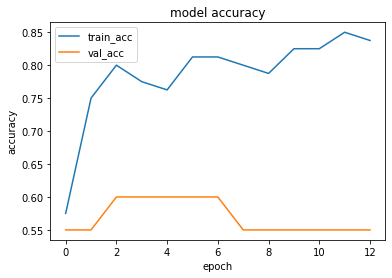

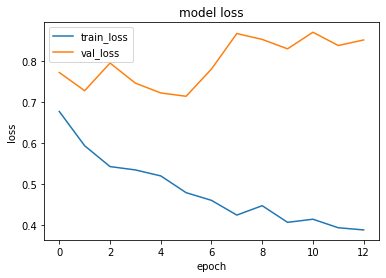

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.4613832]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.8524715]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.7616695]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.34363902]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.25381213]]


1it [00:00, 13662.23it/s]


prediction for video control_3.mov is [[0.33395576]]


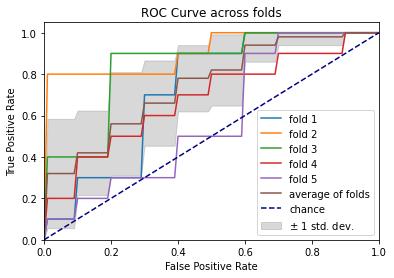

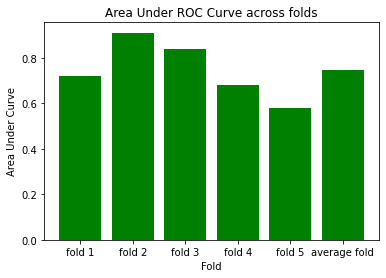

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.7254 - accuracy: 0.4125 - precision: 0.4340 - recall: 0.5750 - val_loss: 0.6712 - val_accuracy: 0.4500 - val_precision: 0.4706 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6730 - accuracy: 0.5750 - precision: 0.5750 - recall: 0.5750 - val_loss: 0.6627 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6571 - accuracy: 0.7000 - precision: 0.8077 - recall: 0.5250 - val_loss: 0.6343 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6098 - accuracy: 0.7625 - precision: 0.7059 - recall: 0.9000 - val_loss: 0.6093 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5/75
3/3 [==============================] - 0s 123ms/s

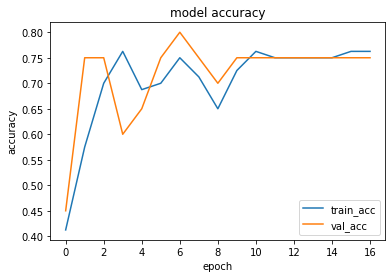

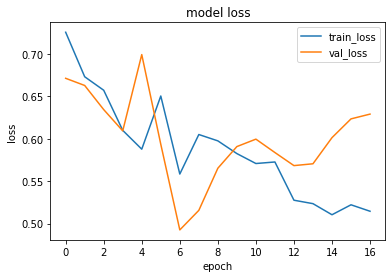

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.17308566]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.5042184]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.46885827]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.13212222]]


1it [00:00, 13486.51it/s]


prediction for video control_2.mov is [[0.11980966]]


1it [00:00, 14563.56it/s]


prediction for video control_3.mov is [[0.12288734]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7458 - accuracy: 0.4375 - precision: 0.4468 - recall: 0.5250 - val_loss: 0.6675 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7084 - accuracy: 0.5375 - precision: 0.6667 - recall: 0.1500 - val_loss: 0.6265 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6660 - accuracy: 0.6500 - precision: 0.6154 - recall: 0.8000 - val_loss: 0.5998 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6183 - accuracy: 0.7125 - precision: 0.7073 - recall: 0.7250 - val_loss: 0.5623 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 5

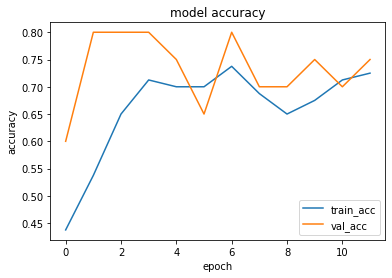

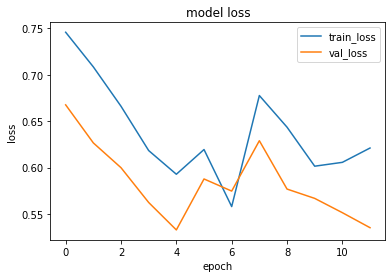

1it [00:00, 11915.64it/s]


prediction for video armflapping_1.mov is [[0.48678228]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.4725483]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.62259203]]


1it [00:00, 13934.56it/s]


prediction for video control_1.mov is [[0.44039327]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.27248365]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.37369353]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6975 - accuracy: 0.4875 - precision: 0.4872 - recall: 0.4750 - val_loss: 0.6607 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6360 - accuracy: 0.6875 - precision: 0.6415 - recall: 0.8500 - val_loss: 0.6835 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5973 - accuracy: 0.7500 - precision: 0.7381 - recall: 0.7750 - val_loss: 0.6592 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5916 - accuracy: 0.7500 - precision: 0.8125 - recall: 0.6500 - val_loss: 0.6709 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5

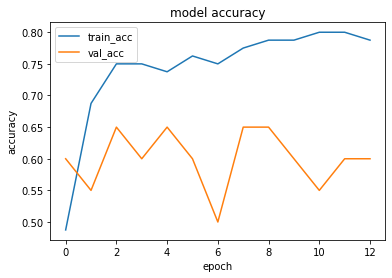

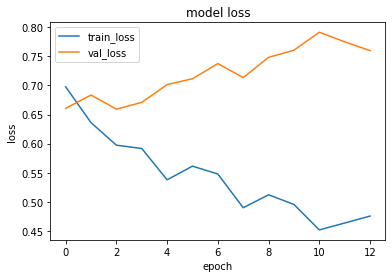

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5392334]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.8099706]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.7627677]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.15627569]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.12616184]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.17051297]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6816 - accuracy: 0.5500 - precision: 0.5556 - recall: 0.5000 - val_loss: 0.6395 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6166 - accuracy: 0.7125 - precision: 0.7179 - recall: 0.7000 - val_loss: 0.6779 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6844 - accuracy: 0.6500 - precision: 0.5968 - recall: 0.9250 - val_loss: 0.7307 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5907 - accuracy: 0.7375 - precision: 0.7209 - recall: 0.7750 - val_loss: 0.6966 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5

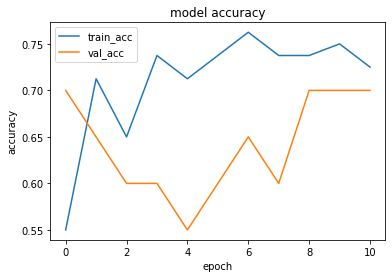

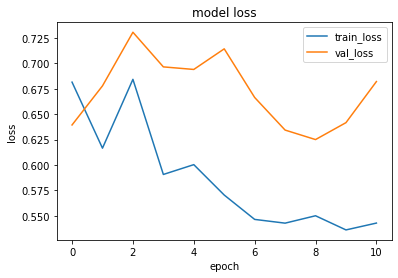

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.41566342]]


1it [00:00, 12300.01it/s]


prediction for video armflapping_3.mov is [[0.27654484]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.5443675]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.30237052]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.22290015]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.23101011]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6903 - accuracy: 0.4250 - precision: 0.4375 - recall: 0.5250 - val_loss: 0.6115 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6580 - accuracy: 0.7000 - precision: 0.7500 - recall: 0.6000 - val_loss: 0.6126 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6260 - accuracy: 0.7125 - precision: 0.6735 - recall: 0.8250 - val_loss: 0.5904 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5982 - accuracy: 0.7125 - precision: 0.7073 - recall: 0.7250 - val_loss: 0.6279 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5

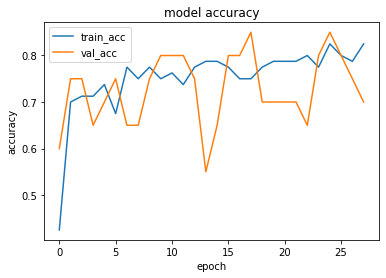

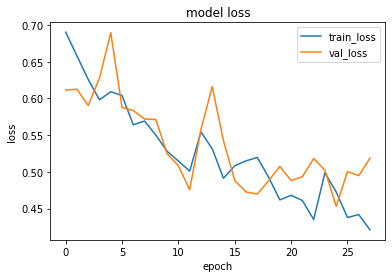

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.54421794]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.7417312]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.66584194]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.3923056]]


1it [00:00, 13934.56it/s]


prediction for video control_2.mov is [[0.2821862]]


1it [00:00, 12865.96it/s]


prediction for video control_3.mov is [[0.23983034]]


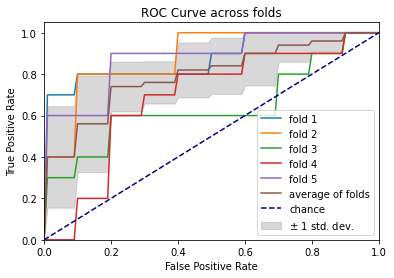

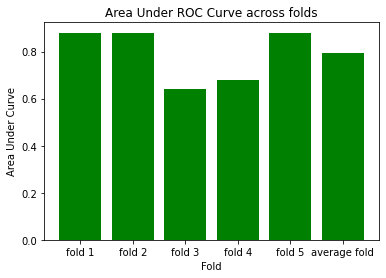

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6848 - accuracy: 0.5250 - precision: 0.5385 - recall: 0.3500 - val_loss: 0.6444 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6830 - accuracy: 0.6375 - precision: 0.6222 - recall: 0.7000 - val_loss: 0.6290 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6237 - accuracy: 0.6750 - precision: 0.6458 - recall: 0.7750 - val_loss: 0.6021 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6269 - accuracy: 0.6875 - precision: 0.6923 - recall: 0.6750 - val_loss: 0.5937 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 128ms/s

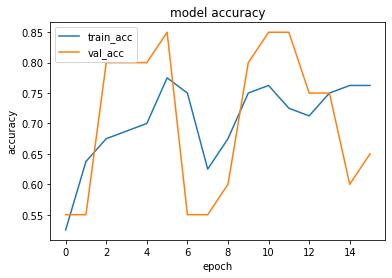

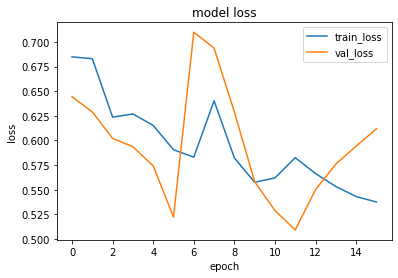

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.47417167]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.52619916]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.6037493]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.30468237]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.24000421]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.24837807]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6909 - accuracy: 0.5625 - precision: 0.5641 - recall: 0.5500 - val_loss: 0.6092 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6719 - accuracy: 0.6250 - precision: 0.5833 - recall: 0.8750 - val_loss: 0.6030 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6159 - accuracy: 0.7125 - precision: 0.7576 - recall: 0.6250 - val_loss: 0.6019 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5863 - accuracy: 0.7375 - precision: 0.7568 - recall: 0.7000 - val_loss: 0.6504 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5

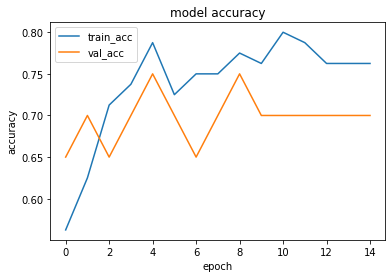

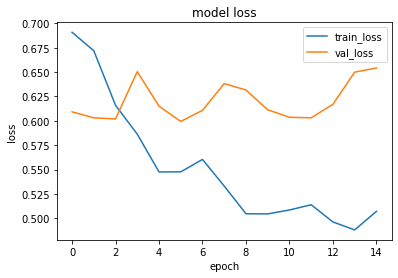

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.676535]]


1it [00:00, 13025.79it/s]


prediction for video armflapping_3.mov is [[0.76586854]]


1it [00:00, 13025.79it/s]


prediction for video armflapping_2.mov is [[0.753795]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.14708519]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.12178019]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.12313321]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7299 - accuracy: 0.4750 - precision: 0.4667 - recall: 0.3500 - val_loss: 0.6516 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6727 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.6344 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6493 - accuracy: 0.6625 - precision: 0.6444 - recall: 0.7250 - val_loss: 0.6132 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6241 - accuracy: 0.7000 - precision: 0.7105 - recall: 0.6750 - val_loss: 0.5701 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 5

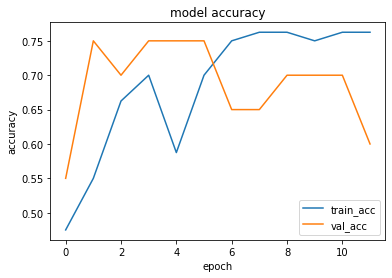

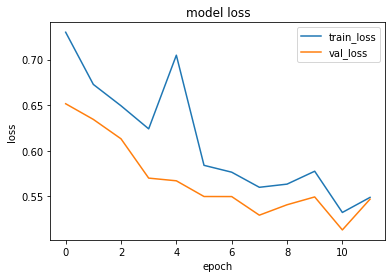

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.2074005]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_3.mov is [[0.60782355]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.61426663]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.18470803]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.18075702]]


1it [00:00, 15087.42it/s]


prediction for video control_3.mov is [[0.17875192]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 127ms/step - loss: 0.7092 - accuracy: 0.4000 - precision: 0.4355 - recall: 0.6750 - val_loss: 0.6885 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6654 - accuracy: 0.6500 - precision: 0.6304 - recall: 0.7250 - val_loss: 0.6512 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6317 - accuracy: 0.7000 - precision: 0.6481 - recall: 0.8750 - val_loss: 0.6206 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6065 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000 - val_loss: 0.5751 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5

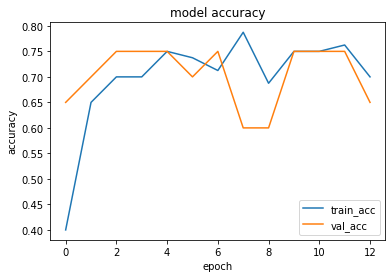

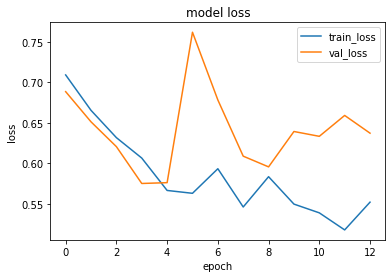

1it [00:00, 12633.45it/s]


prediction for video armflapping_1.mov is [[0.48977453]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.4094256]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.53886724]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.416493]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.33514762]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.3436871]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6690 - accuracy: 0.5250 - precision: 0.5172 - recall: 0.7500 - val_loss: 0.8245 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6623 - accuracy: 0.6750 - precision: 0.6094 - recall: 0.9750 - val_loss: 0.7198 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6042 - accuracy: 0.7250 - precision: 0.8000 - recall: 0.6000 - val_loss: 0.7100 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5762 - accuracy: 0.7625 - precision: 0.7692 - recall: 0.7500 - val_loss: 0.6727 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/

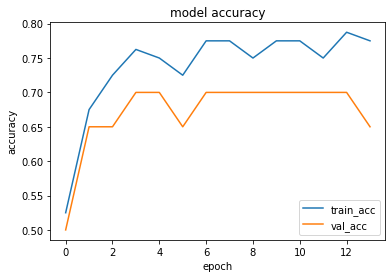

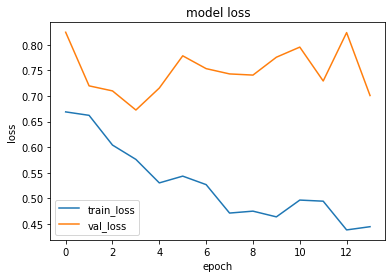

1it [00:00, 13842.59it/s]


prediction for video armflapping_1.mov is [[0.42459437]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.41525537]]


1it [00:00, 12945.38it/s]


prediction for video armflapping_2.mov is [[0.6545476]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.30029947]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.26715153]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.261128]]


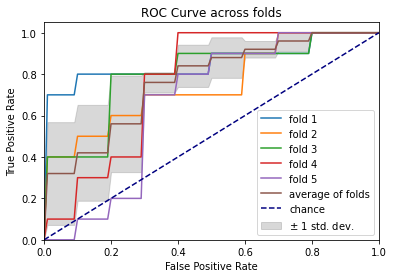

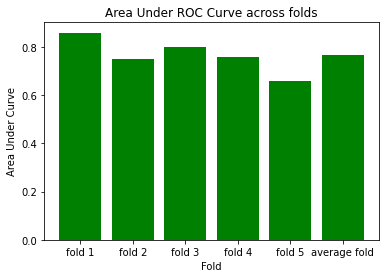

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6916 - accuracy: 0.4750 - precision: 0.4848 - recall: 0.8000 - val_loss: 0.6029 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6785 - accuracy: 0.6000 - precision: 0.5690 - recall: 0.8250 - val_loss: 0.6370 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6177 - accuracy: 0.7625 - precision: 0.7838 - recall: 0.7250 - val_loss: 0.6222 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.5707 - accuracy: 0.7875 - precision: 0.7805 - recall: 0.8000 - val_loss: 0.6500 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 134ms/s

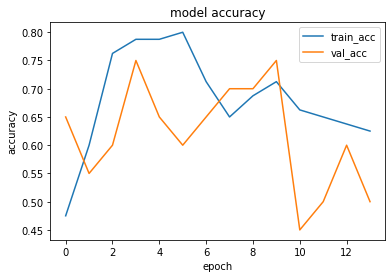

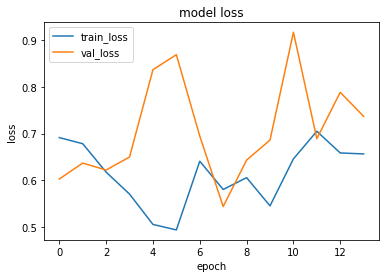

1it [00:00, 12520.31it/s]


prediction for video armflapping_1.mov is [[0.33822244]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.5419739]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.56445086]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.19537616]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.16519916]]


1it [00:00, 13357.66it/s]


prediction for video control_3.mov is [[0.18388617]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.7039 - accuracy: 0.5125 - precision: 0.5238 - recall: 0.2750 - val_loss: 0.7060 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6724 - accuracy: 0.5750 - precision: 0.5484 - recall: 0.8500 - val_loss: 0.6619 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6159 - accuracy: 0.7250 - precision: 0.7500 - recall: 0.6750 - val_loss: 0.6549 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5742 - accuracy: 0.7250 - precision: 0.7143 - recall: 0.7500 - val_loss: 0.6395 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5

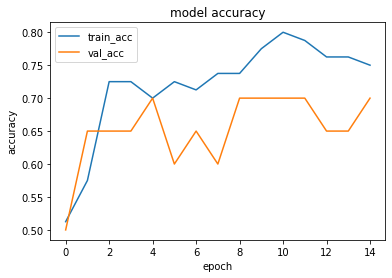

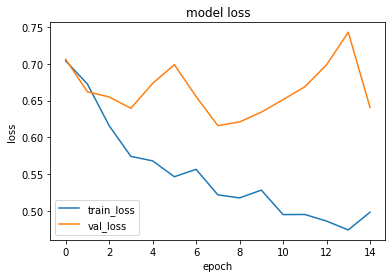

1it [00:00, 12945.38it/s]


prediction for video armflapping_1.mov is [[0.23998022]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_3.mov is [[0.8496648]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.7892635]]


1it [00:00, 10407.70it/s]


prediction for video control_1.mov is [[0.20016009]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.18280736]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.18611377]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6806 - accuracy: 0.6250 - precision: 0.6667 - recall: 0.5000 - val_loss: 0.7281 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6977 - accuracy: 0.5625 - precision: 0.5385 - recall: 0.8750 - val_loss: 0.6251 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6186 - accuracy: 0.7000 - precision: 0.7667 - recall: 0.5750 - val_loss: 0.6325 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6025 - accuracy: 0.7250 - precision: 0.8000 - recall: 0.6000 - val_loss: 0.5857 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5

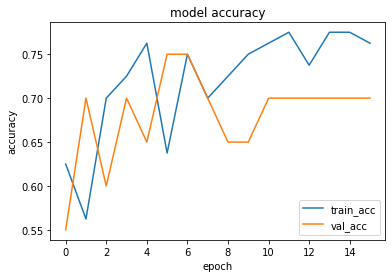

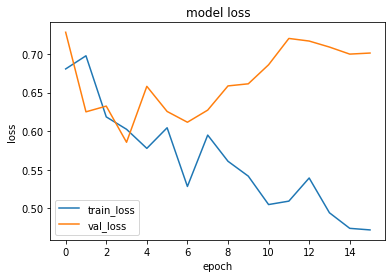

1it [00:00, 11335.96it/s]


prediction for video armflapping_1.mov is [[0.58292645]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.71760494]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.78480875]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.3863322]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.28185868]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.27514434]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7335 - accuracy: 0.4750 - precision: 0.4615 - recall: 0.3000 - val_loss: 0.6446 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6877 - accuracy: 0.5375 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6272 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6388 - accuracy: 0.6875 - precision: 0.7273 - recall: 0.6000 - val_loss: 0.6483 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6628 - accuracy: 0.6250 - precision: 0.8571 - recall: 0.3000 - val_loss: 0.6247 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5

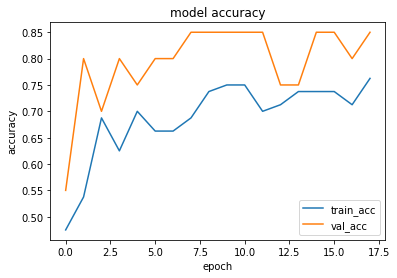

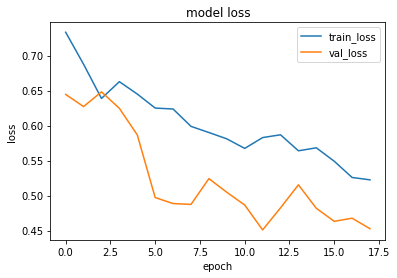

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.45636705]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.5119525]]


1it [00:00, 12483.05it/s]


prediction for video armflapping_2.mov is [[0.6002824]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.36759228]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.32736677]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.30924657]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6718 - accuracy: 0.5500 - precision: 0.5312 - recall: 0.8500 - val_loss: 0.7715 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6163 - accuracy: 0.7250 - precision: 0.6800 - recall: 0.8500 - val_loss: 0.7268 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6968 - accuracy: 0.6250 - precision: 0.8125 - recall: 0.3250 - val_loss: 0.5964 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6169 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.6113 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5

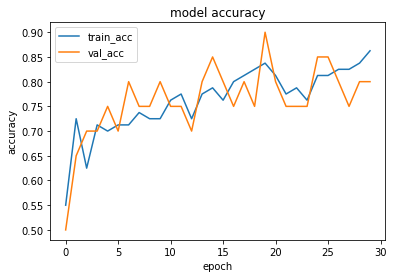

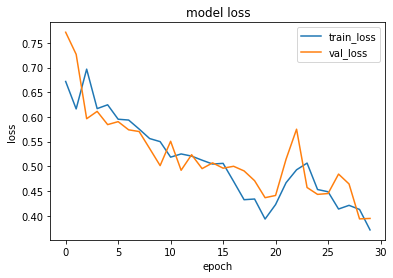

1it [00:00, 12671.61it/s]


prediction for video armflapping_1.mov is [[0.52240217]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.62523776]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.6790792]]


1it [00:00, 14563.56it/s]


prediction for video control_1.mov is [[0.26921982]]


1it [00:00, 13486.51it/s]


prediction for video control_2.mov is [[0.23834285]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.23284277]]


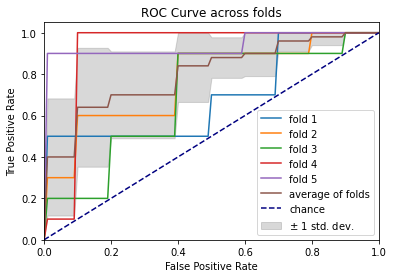

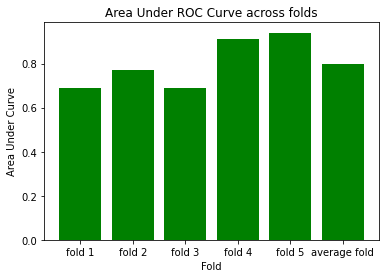

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 168ms/step - loss: 0.7356 - accuracy: 0.6375 - precision: 0.6341 - recall: 0.6500 - val_loss: 0.6896 - val_accuracy: 0.5500 - val_precision: 0.5556 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6457 - accuracy: 0.6625 - precision: 0.7407 - recall: 0.5000 - val_loss: 0.6401 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.5920 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.6830 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.5539 - accuracy: 0.7500 - precision: 0.7381 - recall: 0.7750 - val_loss: 0.6962 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 135ms/s

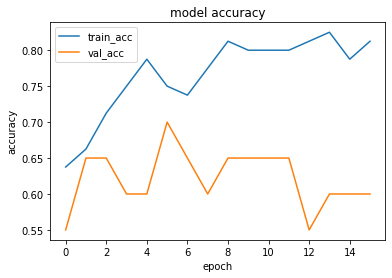

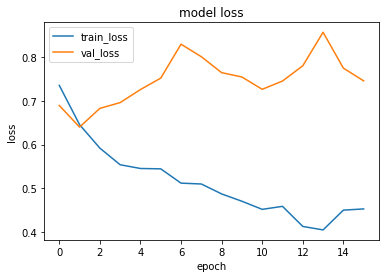

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.5610566]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.54413813]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.7010356]]


1it [00:00, 14217.98it/s]


prediction for video control_1.mov is [[0.4257829]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.34848094]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.33234924]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.7317 - accuracy: 0.4500 - precision: 0.4565 - recall: 0.5250 - val_loss: 0.6786 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6662 - accuracy: 0.6000 - precision: 0.7000 - recall: 0.3500 - val_loss: 0.6769 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6441 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.6999 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6009 - accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.6686 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5

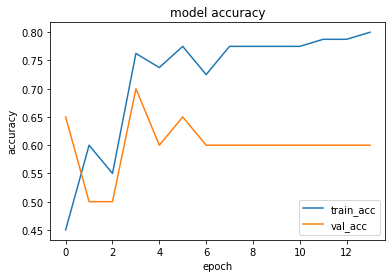

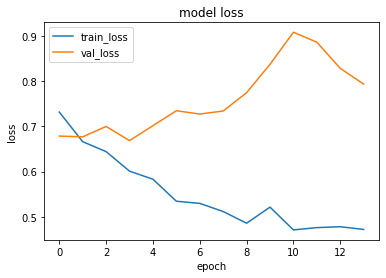

1it [00:00, 11881.88it/s]


prediction for video armflapping_1.mov is [[0.5308246]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.663832]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.73503816]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.41550258]]


1it [00:00, 15087.42it/s]


prediction for video control_2.mov is [[0.3156421]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.3162946]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7749 - accuracy: 0.4375 - precision: 0.3684 - recall: 0.1750 - val_loss: 0.6773 - val_accuracy: 0.4000 - val_precision: 0.4286 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6639 - accuracy: 0.5250 - precision: 0.5143 - recall: 0.9000 - val_loss: 0.6570 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6392 - accuracy: 0.6000 - precision: 0.5625 - recall: 0.9000 - val_loss: 0.6406 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6633 - accuracy: 0.6000 - precision: 0.6667 - recall: 0.4000 - val_loss: 0.6196 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5/

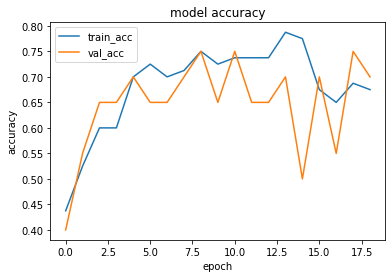

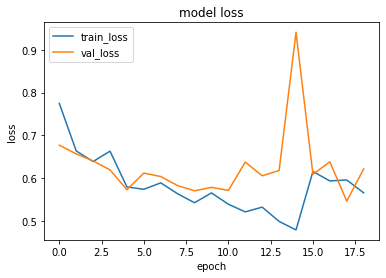

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.5084207]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.583166]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.5929292]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.38857156]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.3387674]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.2793338]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7067 - accuracy: 0.5875 - precision: 0.5593 - recall: 0.8250 - val_loss: 0.7046 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6945 - accuracy: 0.5875 - precision: 0.8182 - recall: 0.2250 - val_loss: 0.6727 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6322 - accuracy: 0.6750 - precision: 0.6667 - recall: 0.7000 - val_loss: 0.6385 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6371 - accuracy: 0.5500 - precision: 0.5286 - recall: 0.9250 - val_loss: 0.6140 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 5/

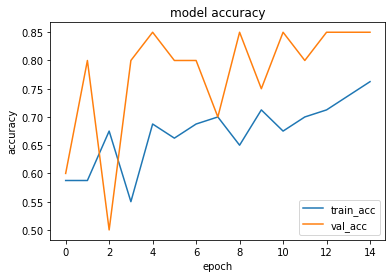

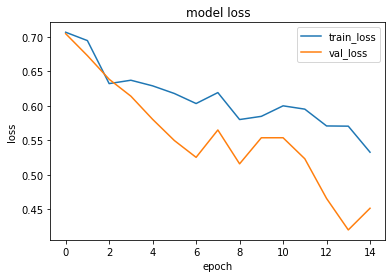

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.49594012]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.49706054]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.525082]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.46645406]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.44581324]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.44622433]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7034 - accuracy: 0.5625 - precision: 0.5510 - recall: 0.6750 - val_loss: 0.5941 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 185ms/step - loss: 0.6601 - accuracy: 0.6125 - precision: 0.6364 - recall: 0.5250 - val_loss: 0.5851 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6063 - accuracy: 0.6875 - precision: 0.6471 - recall: 0.8250 - val_loss: 0.5259 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.5851 - accuracy: 0.7250 - precision: 0.7368 - recall: 0.7000 - val_loss: 0.5283 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5

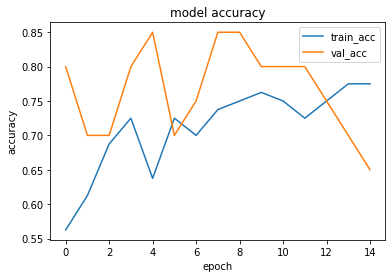

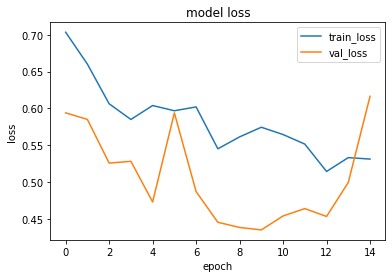

1it [00:00, 12633.45it/s]


prediction for video armflapping_1.mov is [[0.5894298]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.4799853]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.58675206]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.33040577]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.2706673]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.2676506]]


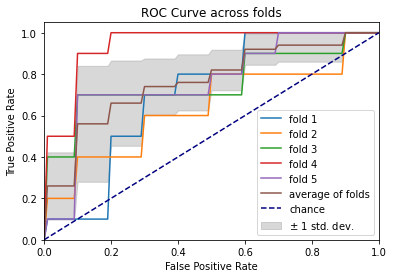

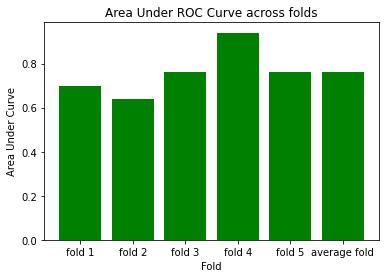

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6732 - accuracy: 0.5500 - precision: 0.5833 - recall: 0.3500 - val_loss: 0.7703 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6445 - accuracy: 0.7000 - precision: 0.6739 - recall: 0.7750 - val_loss: 0.7624 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5690 - accuracy: 0.7500 - precision: 0.7632 - recall: 0.7250 - val_loss: 0.6633 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5707 - accuracy: 0.7250 - precision: 0.7143 - recall: 0.7500 - val_loss: 0.6418 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 120ms/s

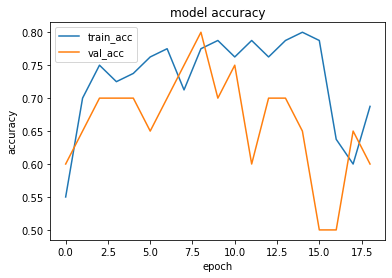

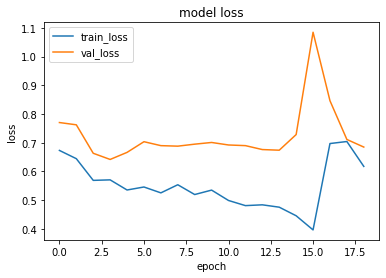

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.48351136]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_3.mov is [[0.58951473]]


1it [00:00, 12787.51it/s]


prediction for video armflapping_2.mov is [[0.52728206]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.42357695]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.40111604]]


1it [00:00, 13486.51it/s]


prediction for video control_3.mov is [[0.40180543]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6699 - accuracy: 0.4875 - precision: 0.4865 - recall: 0.4500 - val_loss: 0.7670 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.7788 - accuracy: 0.5250 - precision: 0.5135 - recall: 0.9500 - val_loss: 0.6665 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6557 - accuracy: 0.7125 - precision: 0.6977 - recall: 0.7500 - val_loss: 0.6674 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6278 - accuracy: 0.7000 - precision: 0.8333 - recall: 0.5000 - val_loss: 0.6340 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5

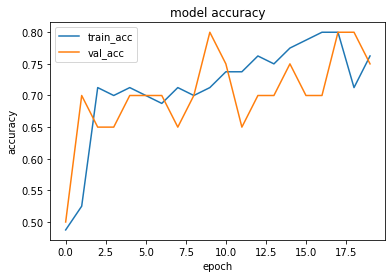

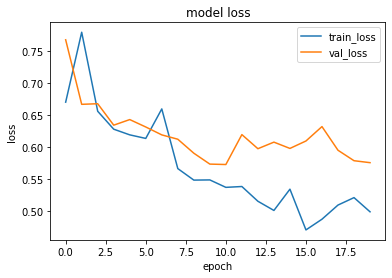

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.4922777]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.27422035]]


1it [00:00, 12336.19it/s]


prediction for video armflapping_2.mov is [[0.6137011]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.28681555]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.25336766]]


1it [00:00, 12372.58it/s]


prediction for video control_3.mov is [[0.25745112]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 127ms/step - loss: 0.7109 - accuracy: 0.5500 - precision: 0.5323 - recall: 0.8250 - val_loss: 0.6735 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6565 - accuracy: 0.5875 - precision: 0.5897 - recall: 0.5750 - val_loss: 0.5961 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6080 - accuracy: 0.7375 - precision: 0.7209 - recall: 0.7750 - val_loss: 0.6357 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5909 - accuracy: 0.7125 - precision: 0.6889 - recall: 0.7750 - val_loss: 0.6412 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 5

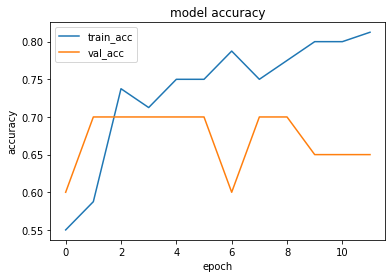

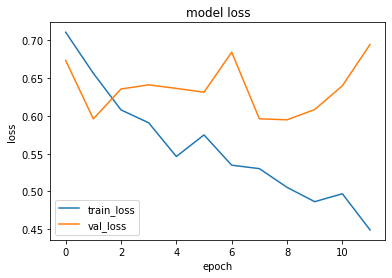

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.16480365]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.8063383]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.8131353]]


1it [00:00, 15087.42it/s]


prediction for video control_1.mov is [[0.14863175]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.06961614]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.16292185]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 191ms/step - loss: 0.6658 - accuracy: 0.6875 - precision: 0.6744 - recall: 0.7250 - val_loss: 0.6574 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6387 - accuracy: 0.6500 - precision: 0.6200 - recall: 0.7750 - val_loss: 0.6468 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5953 - accuracy: 0.7625 - precision: 0.8182 - recall: 0.6750 - val_loss: 0.6482 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5679 - accuracy: 0.7500 - precision: 0.7778 - recall: 0.7000 - val_loss: 0.6711 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5

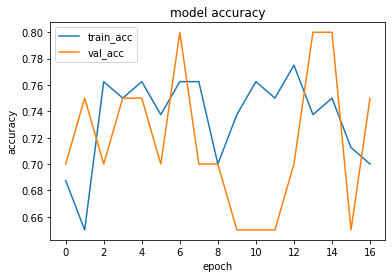

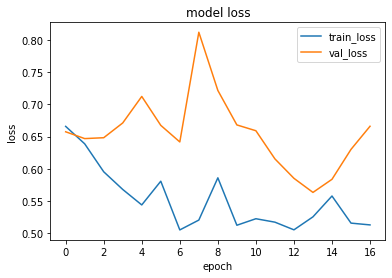

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.67830515]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.7729825]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.7398245]]


1it [00:00, 12633.45it/s]


prediction for video control_1.mov is [[0.1199936]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.06723419]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.0987834]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6716 - accuracy: 0.5750 - precision: 0.5625 - recall: 0.6750 - val_loss: 0.9319 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.7835 - accuracy: 0.4875 - precision: 0.4925 - recall: 0.8250 - val_loss: 0.5798 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6483 - accuracy: 0.6500 - precision: 0.8000 - recall: 0.4000 - val_loss: 0.5961 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6428 - accuracy: 0.6625 - precision: 0.7097 - recall: 0.5500 - val_loss: 0.5863 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5/

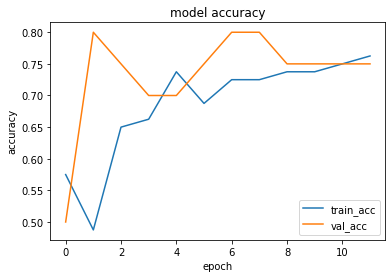

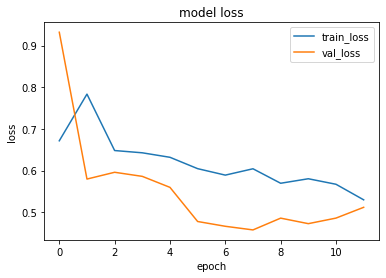

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.711334]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.8334851]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.8222431]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.41562515]]


1it [00:00, 13357.66it/s]


prediction for video control_2.mov is [[0.32061657]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.24292818]]


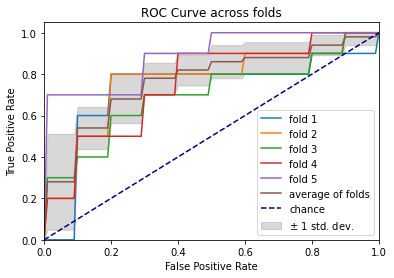

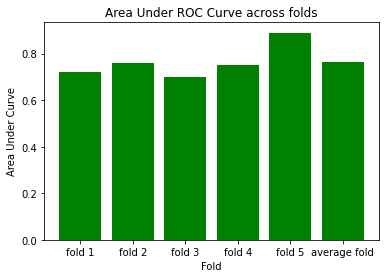

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.7153 - accuracy: 0.4375 - precision: 0.4576 - recall: 0.6750 - val_loss: 0.7427 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6651 - accuracy: 0.4875 - precision: 0.4828 - recall: 0.3500 - val_loss: 0.6563 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5967 - accuracy: 0.6625 - precision: 0.6182 - recall: 0.8500 - val_loss: 0.8129 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6371 - accuracy: 0.6500 - precision: 0.6364 - recall: 0.7000 - val_loss: 0.8683 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/75
3/3 [============================

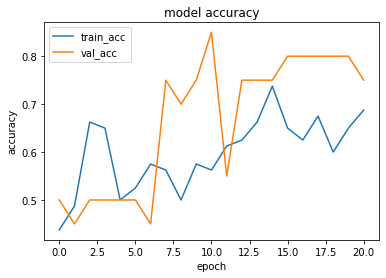

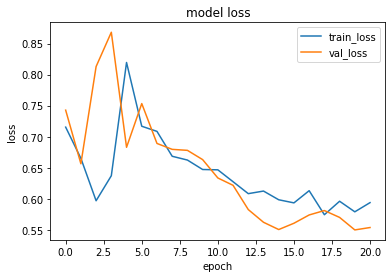

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.49741533]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_3.mov is [[0.5005333]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.51352054]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.49364662]]


1it [00:00, 9341.43it/s]


prediction for video control_2.mov is [[0.4926317]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.49259782]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6941 - accuracy: 0.5250 - precision: 0.5156 - recall: 0.8250 - val_loss: 0.6523 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6352 - accuracy: 0.7375 - precision: 0.7714 - recall: 0.6750 - val_loss: 0.6076 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5991 - accuracy: 0.7000 - precision: 0.7222 - recall: 0.6500 - val_loss: 0.5815 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.5768 - accuracy: 0.7250 - precision: 0.7143 - recall: 0.7500 - val_loss: 0.6058 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5

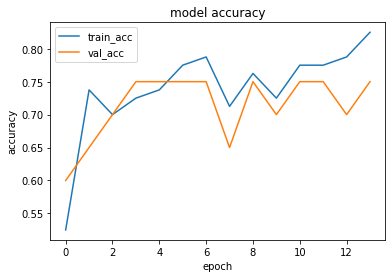

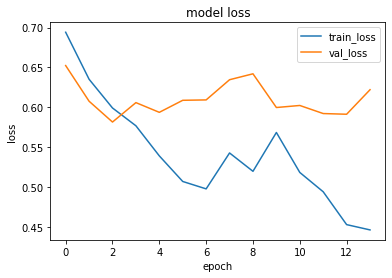

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.24679801]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.4047914]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.5813201]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.26089445]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.25773853]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.23892632]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7596 - accuracy: 0.4500 - precision: 0.4286 - recall: 0.3000 - val_loss: 0.6859 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6657 - accuracy: 0.7125 - precision: 0.6977 - recall: 0.7500 - val_loss: 0.6768 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 183ms/step - loss: 0.6470 - accuracy: 0.7250 - precision: 0.6957 - recall: 0.8000 - val_loss: 0.6381 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6014 - accuracy: 0.7000 - precision: 0.6905 - recall: 0.7250 - val_loss: 0.6028 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5

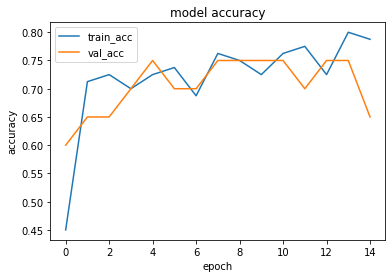

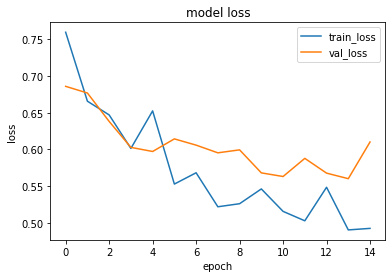

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.4199636]]


1it [00:00, 21399.51it/s]


prediction for video armflapping_3.mov is [[0.4983892]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.63718057]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.21603918]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.20417726]]


1it [00:00, 12372.58it/s]


prediction for video control_3.mov is [[0.20226982]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 126ms/step - loss: 0.8054 - accuracy: 0.3625 - precision: 0.4179 - recall: 0.7000 - val_loss: 0.6817 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6846 - accuracy: 0.7000 - precision: 0.7222 - recall: 0.6500 - val_loss: 0.6813 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6597 - accuracy: 0.6500 - precision: 0.6667 - recall: 0.6000 - val_loss: 0.6482 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6343 - accuracy: 0.6125 - precision: 0.5672 - recall: 0.9500 - val_loss: 0.6072 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5

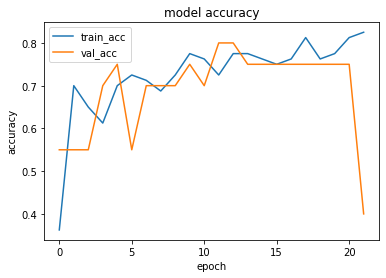

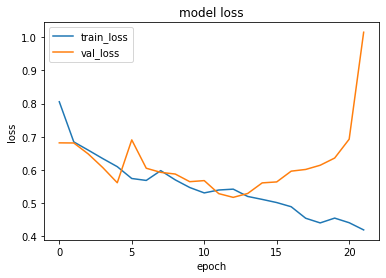

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.6907438]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.78657734]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.81622714]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.496545]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.2884723]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.3381636]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6925 - accuracy: 0.5875 - precision: 0.5946 - recall: 0.5500 - val_loss: 0.5475 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6334 - accuracy: 0.7375 - precision: 0.8065 - recall: 0.6250 - val_loss: 0.6103 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6085 - accuracy: 0.7375 - precision: 0.7879 - recall: 0.6500 - val_loss: 0.6027 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5702 - accuracy: 0.7625 - precision: 0.7692 - recall: 0.7500 - val_loss: 0.6016 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/

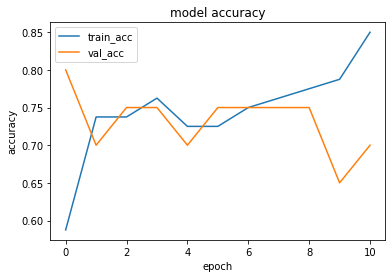

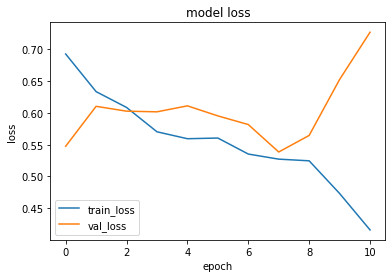

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.20912886]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.4320657]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.7307786]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.14559159]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.13297746]]


1it [00:00, 15420.24it/s]

prediction for video control_3.mov is [[0.13116398]]


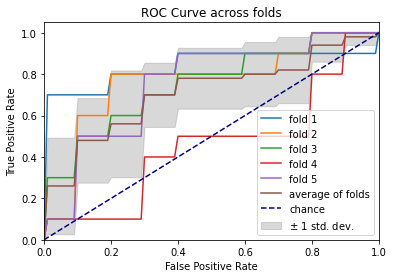

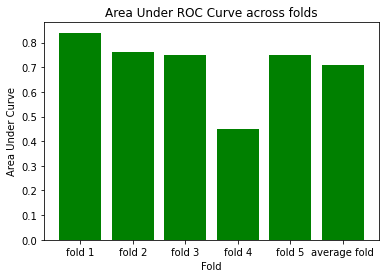

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6844 - accuracy: 0.6125 - precision: 0.6000 - recall: 0.6750 - val_loss: 0.5516 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6323 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.5372 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5857 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.8000 - val_loss: 0.6504 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5894 - accuracy: 0.7375 - precision: 0.7317 - recall: 0.7500 - val_loss: 0.7050 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 129ms/s

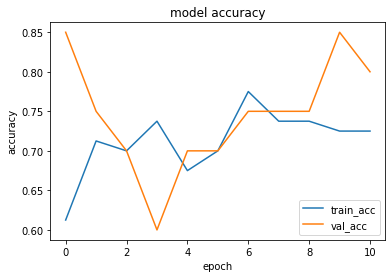

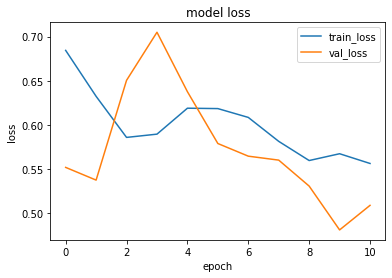

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5149907]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.53150946]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5504183]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.4842261]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.47147322]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.46475542]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6729 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3000 - val_loss: 0.7151 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6158 - accuracy: 0.6125 - precision: 0.5672 - recall: 0.9500 - val_loss: 0.7508 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5479 - accuracy: 0.7875 - precision: 0.7674 - recall: 0.8250 - val_loss: 0.8128 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.5266 - accuracy: 0.7875 - precision: 0.8108 - recall: 0.7500 - val_loss: 0.8564 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 5

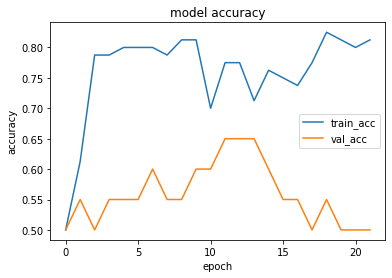

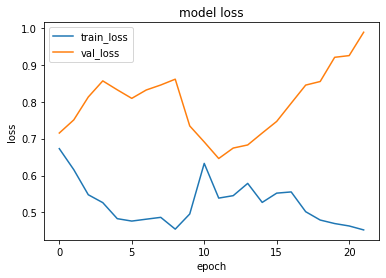

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.2780874]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.16914812]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.86812055]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.18834484]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.17867485]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.17834416]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6765 - accuracy: 0.5625 - precision: 0.5532 - recall: 0.6500 - val_loss: 0.6772 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6598 - accuracy: 0.6125 - precision: 0.5763 - recall: 0.8500 - val_loss: 0.6613 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5885 - accuracy: 0.7250 - precision: 0.7500 - recall: 0.6750 - val_loss: 0.6302 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5707 - accuracy: 0.7375 - precision: 0.7714 - recall: 0.6750 - val_loss: 0.6877 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5

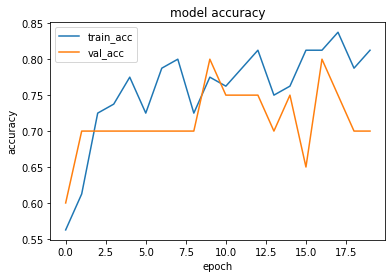

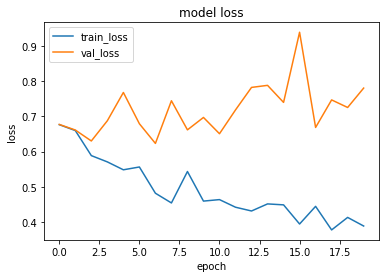

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.43483037]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_3.mov is [[0.7800524]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.7695588]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.31285578]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.2818731]]


1it [00:00, 13662.23it/s]


prediction for video control_3.mov is [[0.27666718]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7155 - accuracy: 0.4375 - precision: 0.4561 - recall: 0.6500 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6618 - accuracy: 0.6125 - precision: 0.5882 - recall: 0.7500 - val_loss: 0.6319 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6530 - accuracy: 0.6875 - precision: 0.7778 - recall: 0.5250 - val_loss: 0.5956 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6320 - accuracy: 0.6875 - precision: 0.6744 - recall: 0.7250 - val_loss: 0.5134 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5

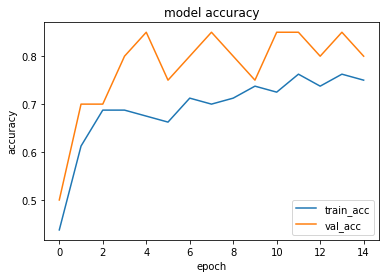

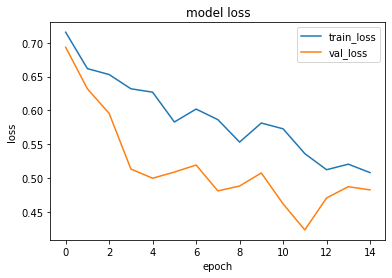

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.55322707]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.63805646]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.7070645]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.4175818]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.38992625]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.33823133]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 136ms/step - loss: 0.6606 - accuracy: 0.7000 - precision: 0.6600 - recall: 0.8250 - val_loss: 0.8212 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6704 - accuracy: 0.6125 - precision: 0.5692 - recall: 0.9250 - val_loss: 0.5941 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6279 - accuracy: 0.7375 - precision: 0.7568 - recall: 0.7000 - val_loss: 0.5958 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5940 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.5783 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5

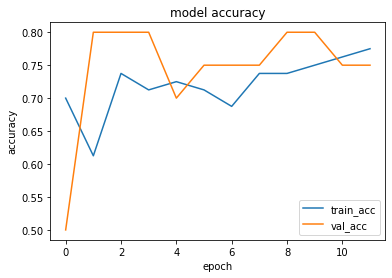

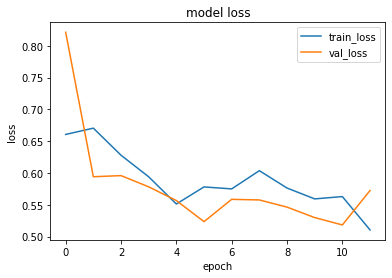

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.32349616]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.7262019]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.728478]]


1it [00:00, 13486.51it/s]


prediction for video control_1.mov is [[0.51977015]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.18284997]]


1it [00:00, 12520.31it/s]


prediction for video control_3.mov is [[0.4358422]]


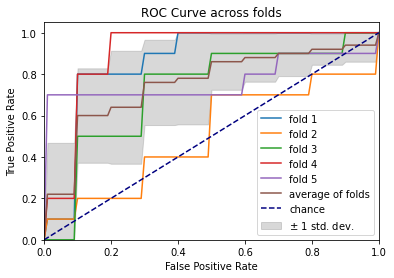

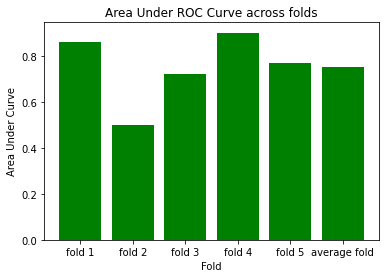

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.7761 - accuracy: 0.5625 - precision: 0.5342 - recall: 0.9750 - val_loss: 0.6853 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6800 - accuracy: 0.6250 - precision: 0.6389 - recall: 0.5750 - val_loss: 0.6569 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6410 - accuracy: 0.7125 - precision: 0.7179 - recall: 0.7000 - val_loss: 0.6539 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6313 - accuracy: 0.6875 - precision: 0.6415 - recall: 0.8500 - val_loss: 0.6259 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 121ms/s

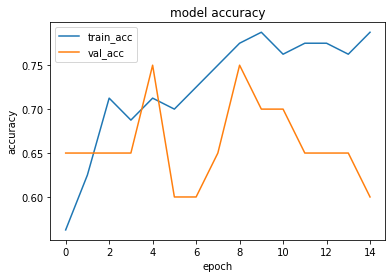

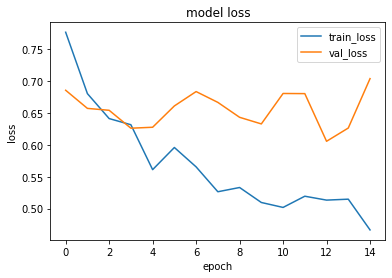

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.13267457]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.19206804]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.18279785]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.1220628]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.11964706]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.11871994]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6744 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.6250 - val_loss: 0.6677 - val_accuracy: 0.4500 - val_precision: 0.4667 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6542 - accuracy: 0.5625 - precision: 0.5385 - recall: 0.8750 - val_loss: 0.6423 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.5859 - accuracy: 0.6875 - precision: 0.6667 - recall: 0.7500 - val_loss: 0.6829 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.5987 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.8000 - val_loss: 0.6631 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5

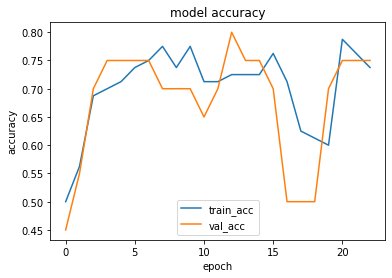

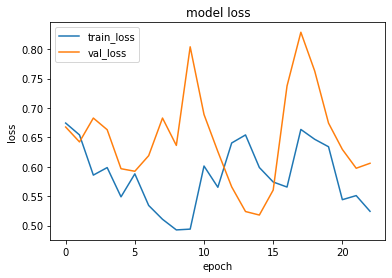

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.5637523]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.59550864]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.576627]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.41986188]]


1it [00:00, 15420.24it/s]


prediction for video control_2.mov is [[0.4427836]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.40486103]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7418 - accuracy: 0.4750 - precision: 0.4762 - recall: 0.5000 - val_loss: 0.7898 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6539 - accuracy: 0.6625 - precision: 0.6102 - recall: 0.9000 - val_loss: 0.7458 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6183 - accuracy: 0.7375 - precision: 0.6939 - recall: 0.8500 - val_loss: 0.6794 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.5999 - accuracy: 0.7000 - precision: 0.7222 - recall: 0.6500 - val_loss: 0.7434 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 5

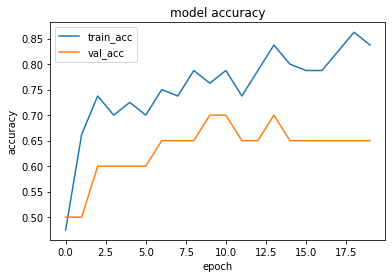

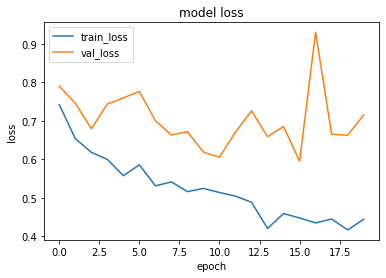

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.26093102]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.7649316]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.7035687]]


1it [00:00, 13486.51it/s]


prediction for video control_1.mov is [[0.21631661]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.21870741]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.22408235]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7124 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.6250 - val_loss: 0.6551 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6512 - accuracy: 0.7125 - precision: 0.8148 - recall: 0.5500 - val_loss: 0.6340 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6098 - accuracy: 0.7250 - precision: 0.6875 - recall: 0.8250 - val_loss: 0.6097 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.5506 - accuracy: 0.7375 - precision: 0.7021 - recall: 0.8250 - val_loss: 0.7552 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5

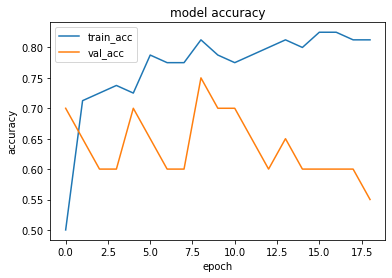

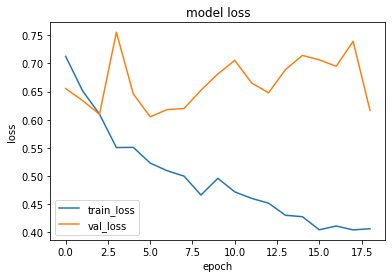

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.6751083]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.9055315]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.82140654]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.37686723]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.21172315]]


1it [00:00, 11522.81it/s]


prediction for video control_3.mov is [[0.33408558]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 1s 203ms/step - loss: 0.6962 - accuracy: 0.4500 - precision: 0.4565 - recall: 0.5250 - val_loss: 0.7271 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6317 - accuracy: 0.6375 - precision: 0.6486 - recall: 0.6000 - val_loss: 0.6605 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6692 - accuracy: 0.5750 - precision: 0.5469 - recall: 0.8750 - val_loss: 0.5880 - val_accuracy: 0.8500 - val_precision: 0.7692 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6228 - accuracy: 0.6625 - precision: 0.6667 - recall: 0.6500 - val_loss: 0.5724 - val_accuracy: 0.9000 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 5

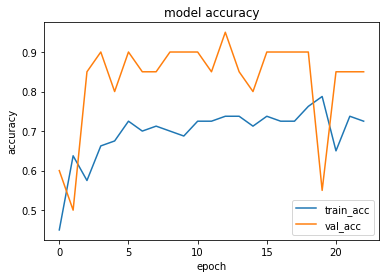

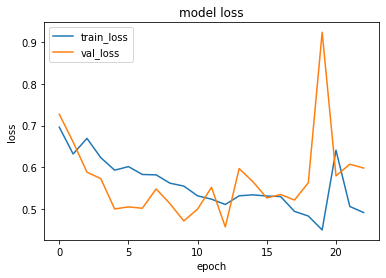

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.53619385]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.49228603]]


1it [00:00, 11881.88it/s]


prediction for video armflapping_2.mov is [[0.6223564]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.45890784]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.36058056]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.36829495]]


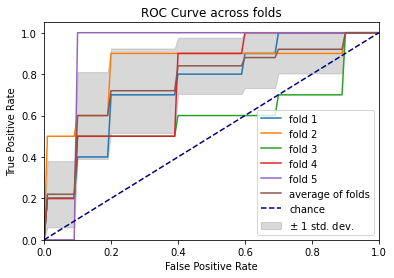

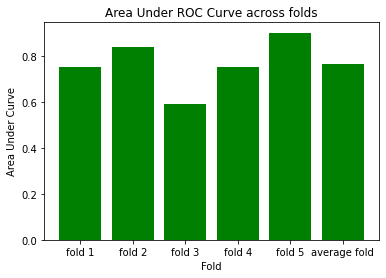

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6942 - accuracy: 0.4500 - precision: 0.4583 - recall: 0.5500 - val_loss: 0.8207 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.7483 - accuracy: 0.5125 - precision: 0.5172 - recall: 0.3750 - val_loss: 0.6289 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6340 - accuracy: 0.6125 - precision: 0.5652 - recall: 0.9750 - val_loss: 0.6589 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6242 - accuracy: 0.6875 - precision: 0.6415 - recall: 0.8500 - val_loss: 0.6159 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s

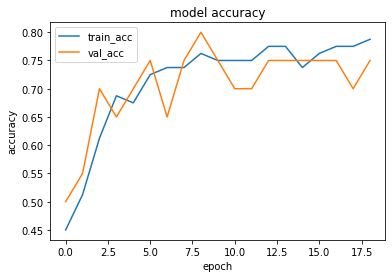

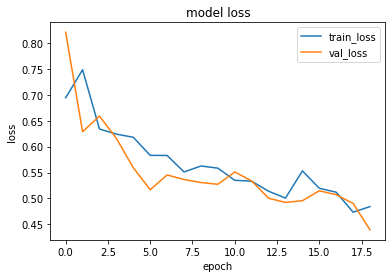

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.5007085]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.500391]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.59509504]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.3921939]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.33847186]]


1it [00:00, 13189.64it/s]


prediction for video control_3.mov is [[0.30992508]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6972 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4000 - val_loss: 0.6803 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5980 - accuracy: 0.6500 - precision: 0.6034 - recall: 0.8750 - val_loss: 0.9702 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6212 - accuracy: 0.7500 - precision: 0.7632 - recall: 0.7250 - val_loss: 0.6743 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 197ms/step - loss: 0.6142 - accuracy: 0.6875 - precision: 0.6364 - recall: 0.8750 - val_loss: 0.6577 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 5

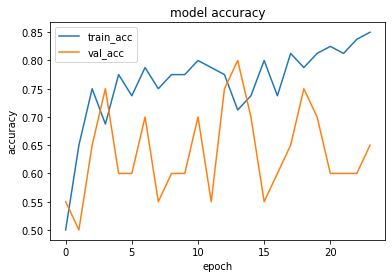

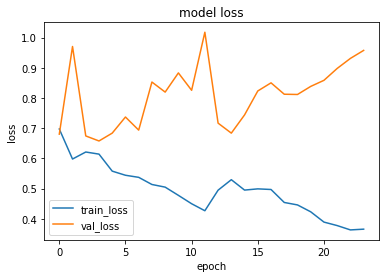

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.45100126]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.62662923]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.59333533]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.32348645]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.29857582]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.29330343]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7270 - accuracy: 0.4750 - precision: 0.4667 - recall: 0.3500 - val_loss: 0.6917 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6967 - accuracy: 0.4875 - precision: 0.4923 - recall: 0.8000 - val_loss: 0.6689 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6437 - accuracy: 0.7125 - precision: 0.6977 - recall: 0.7500 - val_loss: 0.6470 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6087 - accuracy: 0.7125 - precision: 0.6889 - recall: 0.7750 - val_loss: 0.5996 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5

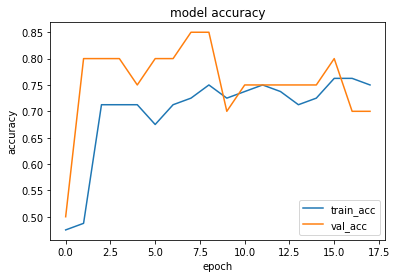

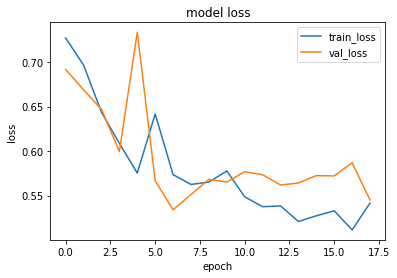

1it [00:00, 13934.56it/s]


prediction for video armflapping_1.mov is [[0.50618786]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_3.mov is [[0.5532165]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.61489356]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.41788918]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.3913798]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.3650107]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7096 - accuracy: 0.4125 - precision: 0.4340 - recall: 0.5750 - val_loss: 0.6410 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6600 - accuracy: 0.6875 - precision: 0.7586 - recall: 0.5500 - val_loss: 0.6103 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6626 - accuracy: 0.7125 - precision: 0.6604 - recall: 0.8750 - val_loss: 0.6299 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6076 - accuracy: 0.7125 - precision: 0.7073 - recall: 0.7250 - val_loss: 0.6064 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5/

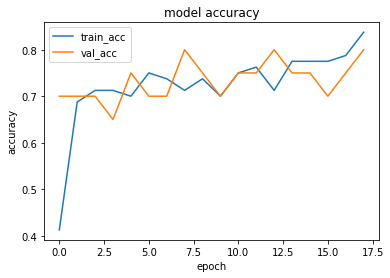

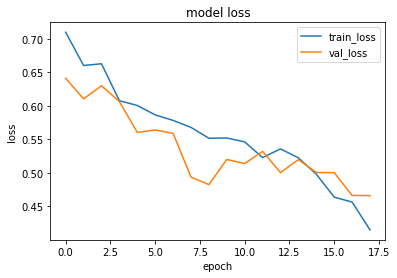

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.6436686]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.81422454]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.8143028]]


1it [00:00, 12336.19it/s]


prediction for video control_1.mov is [[0.36715007]]


1it [00:00, 14027.77it/s]


prediction for video control_2.mov is [[0.27955076]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.2292363]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6946 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.8250 - val_loss: 0.6644 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6443 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.6000 - val_loss: 0.6308 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6150 - accuracy: 0.7250 - precision: 0.7045 - recall: 0.7750 - val_loss: 0.6442 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5402 - accuracy: 0.7500 - precision: 0.7381 - recall: 0.7750 - val_loss: 0.5908 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5/

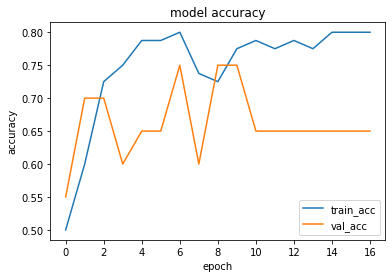

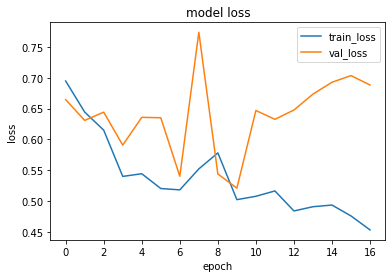

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.39169937]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.7414428]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.7800597]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.2777707]]


1it [00:00, 12372.58it/s]


prediction for video control_2.mov is [[0.23838809]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.23876494]]


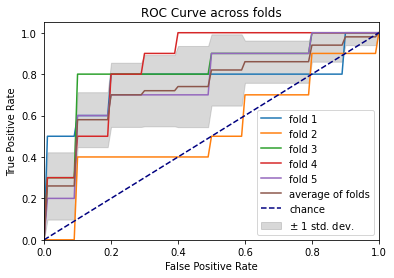

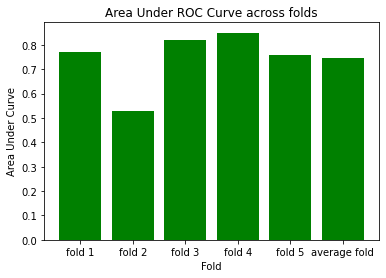

(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6895 - accuracy: 0.5875 - precision: 0.5745 - recall: 0.6750 - val_loss: 0.6705 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6123 - accuracy: 0.6500 - precision: 0.6250 - recall: 0.7500 - val_loss: 0.6242 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5994 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.7487 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6184 - accuracy: 0.6875 - precision: 0.7586 - recall: 0.5500 - val_loss: 0.6280 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 124ms/s

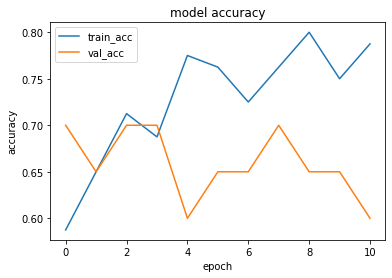

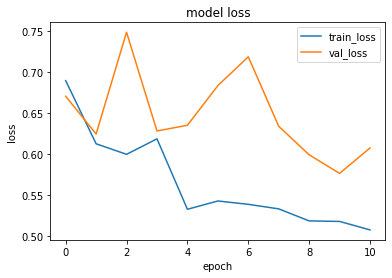

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.5125919]]


1it [00:00, 19878.22it/s]


prediction for video armflapping_3.mov is [[0.52292246]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.52598226]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.50068337]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.49494368]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.49433988]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7139 - accuracy: 0.4625 - precision: 0.4681 - recall: 0.5500 - val_loss: 0.6838 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6413 - accuracy: 0.6625 - precision: 0.6327 - recall: 0.7750 - val_loss: 0.7029 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5923 - accuracy: 0.7250 - precision: 0.6800 - recall: 0.8500 - val_loss: 0.7138 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5636 - accuracy: 0.7125 - precision: 0.7742 - recall: 0.6000 - val_loss: 0.8699 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5

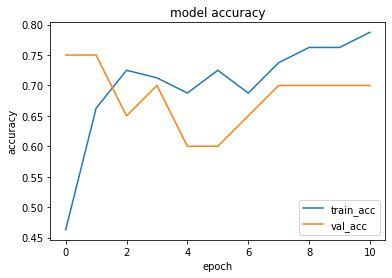

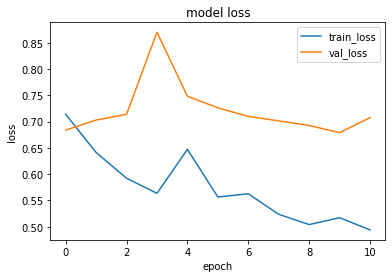

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.5068464]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.53794736]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.52023625]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.49434286]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.4889995]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.49006665]]
(40, 90, 36) (40, 90, 36)
(10, 90, 36) (10, 90, 36)
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6850 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.7000 - val_loss: 0.6341 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6790 - accuracy: 0.5875 - precision: 0.5636 - recall: 0.7750 - val_loss: 0.5768 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6161 - accuracy: 0.6500 - precision: 0.6667 - recall: 0.6000 - val_loss: 0.5648 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6074 - accuracy: 0.6375 - precision: 0.5932 - recall: 0.8750 - val_loss: 0.5334 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5

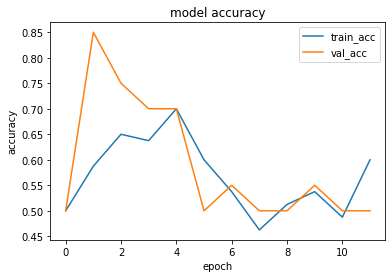

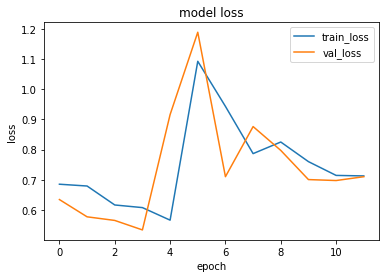

ZeroDivisionError: float division by zero

In [15]:
for seed in SEEDS:
    """ the only problem with this is that it's a basically 100 seed loop, which will take around 500 minutes of running"""
    np.random.seed(seed) # set seed 
    
    # first sort all of the folds 
    N = np.random.permutation(ARMFLAPPING_FRAMES.shape[0])
    ARMFLAPPING_FRAMES = ARMFLAPPING_FRAMES[N]
    CONTROL_FRAMES = CONTROL_FRAMES[N]

    # split them into 5 folds 
    ARMFLAPPING_FRAMES_SPLIT = np.array_split(ARMFLAPPING_FRAMES, 5)
    CONTROL_FRAMES_SPLIT = np.array_split(CONTROL_FRAMES, 5)

    # then run them 5x 
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
    cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

In [60]:
with open("six_landmarks_hundred_seeds_results", 'wb') as f: 
    pickle.dump((META_RESULT_MATRIX, AVERAGE_AUROCS, AVERAGE_TPRS), f)

In [4]:
import pickle, numpy as np
with open("six_landmarks_hundred_seeds_results", 'rb') as f: 
 (META_RESULT_MATRIX, AVERAGE_AUROCS, AVERAGE_TPRS) = pickle.load(f)

In [19]:
META_RESULT_MATRIX = np.array(META_RESULT_MATRIX)
np.mean(META_RESULT_MATRIX, axis=0)

array([0.77156863, 0.78852951, 0.75073529, 0.76623083, 0.69264706,
       0.71044417, 0.68235294, 0.6840341 ])

In [20]:
for i in range(8): 
    print(np.mean(META_RESULT_MATRIX[:, i], axis=0), np.std(META_RESULT_MATRIX[:, i], axis=0))

0.77156862616539 0.05263162875743609
0.7885295082541073 0.06625353320596558
0.7507352916633382 0.07288319117971892
0.7662308274779357 0.05353078114076394
0.6926470577132469 0.09112506615004283
0.7104441657954571 0.12179078134032097
0.6823529420676184 0.15429266510753956
0.6840341018808982 0.1078606955360696


In [21]:
METRICS = []
for fold_results in np.array_split(META_RESULT_MATRIX, 100):
    METRICS.append(np.mean(fold_results, axis = 0)) 

METRICS = np.around(np.array(METRICS), 3)

print(f"training accuracy : {np.mean(METRICS[:, 0])} +/- {np.std(METRICS[:, 0])}")
print(f"training precision : {np.mean(METRICS[:, 1])} +/- {np.std(METRICS[:, 1])}")
print(f"training recall : {np.mean(METRICS[:, 2])} +/- {np.std(METRICS[:, 2])}")
print(f"training f1 : {np.mean(METRICS[:, 3])} +/- {np.std(METRICS[:, 3])}")
print(f"validation accuracy : {np.mean(METRICS[:, 4])} +/- {np.std(METRICS[:, 4])}")
print(f"validation precision : {np.mean(METRICS[:, 5])} +/- {np.std(METRICS[:, 5])}")
print(f"validation recall : {np.mean(METRICS[:, 6])} +/- {np.std(METRICS[:, 6])}")
print(f"validation f1 : {np.mean(METRICS[:, 7])} +/- {np.std(METRICS[:, 7])}")

training accuracy : 0.77106 +/- 0.05290043856150912
training precision : 0.7879999999999999 +/- 0.06668912954897523
training recall : 0.7505 +/- 0.07262747414030037
training f1 : 0.76579 +/- 0.05372919039032693
validation accuracy : 0.6934999999999999 +/- 0.09107826304887462
validation precision : 0.71184 +/- 0.12230541443452125
validation recall : 0.6825000000000001 +/- 0.15171931320698762
validation f1 : 0.6848399999999999 +/- 0.10686858471973884


In [14]:
# create plots of evreything 

training_acc = np.mean(META_RESULT_MATRIX[:, 0], axis=0)

labels = ['Accuracy', "Precision", "Recall", "F1"]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric')
if FOLD_NUMBER != 5: 
    ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
else: 
    ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right")

array([[0.80000001, 0.80000001, 0.80000001, 0.80000001, 0.60000002,
        0.60000002, 0.60000002, 0.60000002],
       [0.77499998, 0.76190478, 0.80000001, 0.78048782, 0.64999998,
        0.66666669, 0.60000002, 0.63157897],
       [0.75      , 0.72727275, 0.80000001, 0.76190478, 0.69999999,
        0.69999999, 0.69999999, 0.69999999],
       [0.85000002, 0.8888889 , 0.80000001, 0.84210527, 0.69999999,
        0.69999999, 0.69999999, 0.69999999],
       [0.72500002, 0.72500002, 0.72500002, 0.72500002, 0.85000002,
        0.81818181, 0.89999998, 0.85714284]])

0.7636873058008137


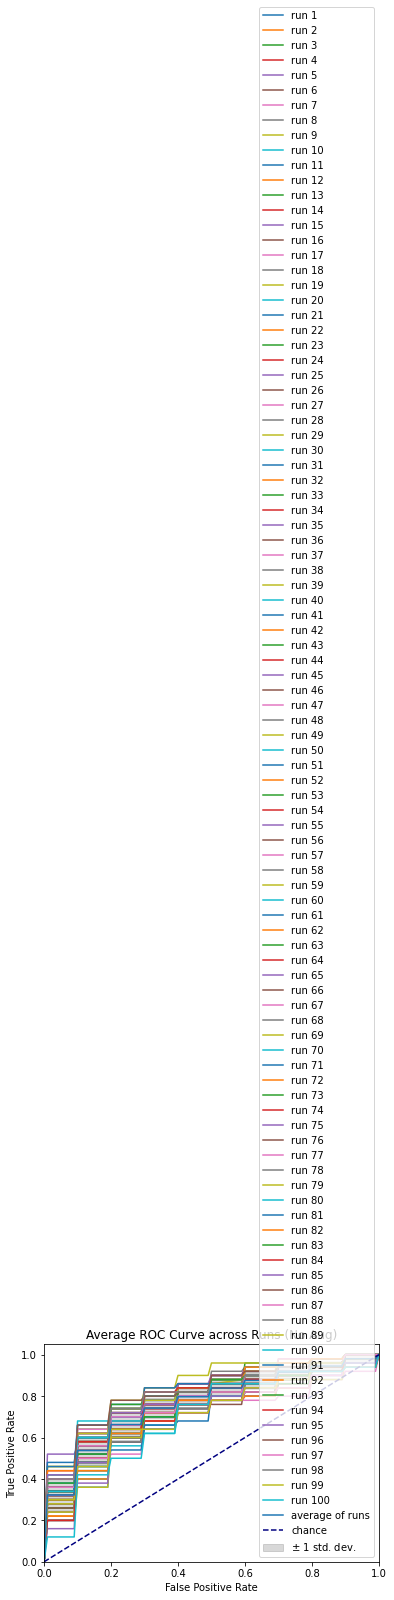

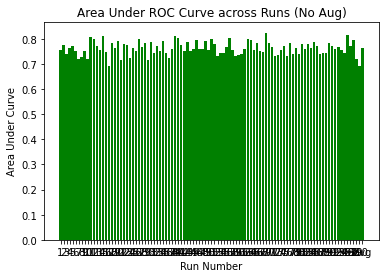

In [39]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [40]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.76189, 0.026550118867552906)

In [41]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [42]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 
import numpy as np
meta_results = []
meta_results.append("3/3 [==============================] - 0s 143ms/step - loss: 0.5490 - accuracy: 0.7625 - precision_127: 0.7692 - recall_127: 0.7500 - val_loss: 0.6196 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5468 - accuracy: 0.7500 - precision_128: 0.7381 - recall_128: 0.7750 - val_loss: 0.4929 - val_accuracy: 0.7500 - val_precision_128: 0.7778 - val_recall_128: 0.7000")
meta_results.append("3/3 [==============================] - 0s 148ms/step - loss: 0.5195 - accuracy: 0.7875 - precision_129: 0.8485 - recall_129: 0.7000 - val_loss: 0.6768 - val_accuracy: 0.6500 - val_precision_129: 0.7143 - val_recall_129: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5528 - accuracy: 0.7375 - precision_130: 0.8800 - recall_130: 0.5500 - val_loss: 0.6188 - val_accuracy: 0.7000 - val_precision_130: 0.7500 - val_recall_130: 0.6000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5276 - accuracy: 0.7500 - precision_131: 0.7500 - recall_131: 0.7500 - val_loss: 0.5546 - val_accuracy: 0.7500 - val_precision_131: 0.7778 - val_recall_131: 0.7000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.3641 - accuracy: 0.8250 - precision_133: 0.9333 - recall_133: 0.7000 - val_loss: 0.8364 - val_accuracy: 0.7000 - val_precision_133: 0.6429 - val_recall_133: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5302 - accuracy: 0.7750 - precision_134: 0.7750 - recall_134: 0.7750 - val_loss: 0.5209 - val_accuracy: 0.8000 - val_precision_134: 0.8000 - val_recall_134: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5198 - accuracy: 0.7375 - precision_135: 0.7209 - recall_135: 0.7750 - val_loss: 0.6696 - val_accuracy: 0.5500 - val_precision_135: 0.5714 - val_recall_135: 0.4000")
meta_results.append('3/3 [==============================] - 0s 142ms/step - loss: 0.5037 - accuracy: 0.7875 - precision_136: 0.8108 - recall_136: 0.7500 - val_loss: 0.5018 - val_accuracy: 0.7500 - val_precision_136: 0.7273 - val_recall_136: 0.8000')
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.6638 - accuracy: 0.6000 - precision_137: 0.6053 - recall_137: 0.5750 - val_loss: 0.6271 - val_accuracy: 0.6000 - val_precision_137: 0.6250 - val_recall_137: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4704 - accuracy: 0.7875 - precision_139: 0.8485 - recall_139: 0.7000 - val_loss: 0.6656 - val_accuracy: 0.7000 - val_precision_139: 0.6667 - val_recall_139: 0.8000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.6160 - accuracy: 0.6500 - precision_140: 0.6875 - recall_140: 0.5500 - val_loss: 0.5326 - val_accuracy: 0.8500 - val_precision_140: 0.8182 - val_recall_140: 0.9000")
meta_results.append("3/3 [==============================] - 0s 134ms/step - loss: 0.4795 - accuracy: 0.7625 - precision_141: 0.7838 - recall_141: 0.7250 - val_loss: 0.7107 - val_accuracy: 0.6500 - val_precision_141: 0.8000 - val_recall_141: 0.4000")
meta_results.append("3/3 [==============================] - 0s 121ms/step - loss: 0.5433 - accuracy: 0.7375 - precision_142: 0.9130 - recall_142: 0.5250 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_142: 0.7000 - val_recall_142: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.4387 - accuracy: 0.8375 - precision_143: 0.9091 - recall_143: 0.7500 - val_loss: 0.8756 - val_accuracy: 0.7000 - val_precision_143: 0.6429 - val_recall_143: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5071 - accuracy: 0.7750 - precision_145: 0.8235 - recall_145: 0.7000 - val_loss: 0.6108 - val_accuracy: 0.7000 - val_precision_145: 0.6429 - val_recall_145: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4103 - accuracy: 0.7875 - precision_146: 0.7674 - recall_146: 0.8250 - val_loss: 0.6352 - val_accuracy: 0.7500 - val_precision_146: 0.7273 - val_recall_146: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5201 - accuracy: 0.7375 - precision_147: 0.8065 - recall_147: 0.6250 - val_loss: 0.7552 - val_accuracy: 0.5500 - val_precision_147: 0.6000 - val_recall_147: 0.3000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4809 - accuracy: 0.7750 - precision_148: 0.7750 - recall_148: 0.7750 - val_loss: 0.5301 - val_accuracy: 0.7500 - val_precision_148: 0.7273 - val_recall_148: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.6238 - accuracy: 0.7250 - precision_149: 0.6957 - recall_149: 0.8000 - val_loss: 0.5609 - val_accuracy: 0.7000 - val_precision_149: 0.7500 - val_recall_149: 0.6000")
meta_results.append("3/3 [==============================] - 0s 147ms/step - loss: 0.4444 - accuracy: 0.8125 - precision_151: 0.8571 - recall_151: 0.7500 - val_loss: 0.6537 - val_accuracy: 0.7000 - val_precision_151: 0.6667 - val_recall_151: 0.8000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4550 - accuracy: 0.8000 - precision_152: 0.7500 - recall_152: 0.9000 - val_loss: 0.6105 - val_accuracy: 0.7500 - val_precision_152: 0.7778 - val_recall_152: 0.7000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.4810 - accuracy: 0.7625 - precision_153: 0.8000 - recall_153: 0.7000 - val_loss: 0.6956 - val_accuracy: 0.6500 - val_precision_153: 0.7143 - val_recall_153: 0.5000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.4951 - accuracy: 0.7625 - precision_154: 0.7692 - recall_154: 0.7500 - val_loss: 0.5621 - val_accuracy: 0.7500 - val_precision_154: 0.7273 - val_recall_154: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_155: 0.8421 - recall_155: 0.8000 - val_loss: 0.5144 - val_accuracy: 0.7500 - val_precision_155: 0.7778 - val_recall_155: 0.7000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.5146 - accuracy: 0.7375 - precision_157: 0.7568 - recall_157: 0.7000 - val_loss: 0.6470 - val_accuracy: 0.7000 - val_precision_157: 0.6429 - val_recall_157: 0.9000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5297 - accuracy: 0.7750 - precision_158: 0.7895 - recall_158: 0.7500 - val_loss: 0.5801 - val_accuracy: 0.7500 - val_precision_158: 0.7778 - val_recall_158: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4522 - accuracy: 0.7750 - precision_159: 0.8056 - recall_159: 0.7250 - val_loss: 0.6115 - val_accuracy: 0.6000 - val_precision_159: 0.7500 - val_recall_159: 0.3000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.5559 - accuracy: 0.7250 - precision_160: 0.6957 - recall_160: 0.8000 - val_loss: 0.5596 - val_accuracy: 0.7000 - val_precision_160: 0.6667 - val_recall_160: 0.8000")
meta_results.append("3/3 [==============================] - 0s 175ms/step - loss: 0.5519 - accuracy: 0.7750 - precision_161: 0.8438 - recall_161: 0.6750 - val_loss: 0.5466 - val_accuracy: 0.6500 - val_precision_161: 0.7143 - val_recall_161: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4980 - accuracy: 0.7750 - precision_163: 0.8235 - recall_163: 0.7000 - val_loss: 0.6757 - val_accuracy: 0.6500 - val_precision_163: 0.6154 - val_recall_163: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4898 - accuracy: 0.7750 - precision_164: 0.7895 - recall_164: 0.7500 - val_loss: 0.6056 - val_accuracy: 0.7000 - val_precision_164: 0.7000 - val_recall_164: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.5320 - accuracy: 0.7375 - precision_165: 0.7209 - recall_165: 0.7750 - val_loss: 0.7340 - val_accuracy: 0.6500 - val_precision_165: 0.6364 - val_recall_165: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4484 - accuracy: 0.7750 - precision_166: 0.7895 - recall_166: 0.7500 - val_loss: 0.5302 - val_accuracy: 0.7500 - val_precision_166: 0.7273 - val_recall_166: 0.8000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6792 - accuracy: 0.6750 - precision_167: 0.6522 - recall_167: 0.7500 - val_loss: 0.6917 - val_accuracy: 0.5500 - val_precision_167: 0.5556 - val_recall_167: 0.5000")
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.4365 - accuracy: 0.8125 - precision_169: 0.8788 - recall_169: 0.7250 - val_loss: 0.7150 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5207 - accuracy: 0.7750 - precision_170: 0.7750 - recall_170: 0.7750 - val_loss: 0.5656 - val_accuracy: 0.7500 - val_precision_170: 0.7778 - val_recall_170: 0.7000")
meta_results.append("3/3 [==============================] - 0s 131ms/step - loss: 0.4846 - accuracy: 0.7625 - precision_171: 0.7692 - recall_171: 0.7500 - val_loss: 0.7023 - val_accuracy: 0.6500 - val_precision_171: 0.6667 - val_recall_171: 0.6000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_172: 0.8824 - recall_172: 0.7500 - val_loss: 0.8445 - val_accuracy: 0.7000 - val_precision_172: 0.7500 - val_recall_172: 0.6000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.6846 - accuracy: 0.5750 - precision_173: 0.5682 - recall_173: 0.6250 - val_loss: 0.6460 - val_accuracy: 0.6000 - val_precision_173: 0.6250 - val_recall_173: 0.5000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4731 - accuracy: 0.7625 - precision_175: 0.7838 - recall_175: 0.7250 - val_loss: 0.6003 - val_accuracy: 0.7500 - val_precision_175: 0.6923 - val_recall_175: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.6343 - accuracy: 0.6875 - precision_176: 0.6744 - recall_176: 0.7250 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_176: 1.0000 - val_recall_176: 0.4000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6491 - accuracy: 0.5875 - precision_177: 0.6061 - recall_177: 0.5000 - val_loss: 0.6270 - val_accuracy: 0.6000 - val_precision_177: 1.0000 - val_recall_177: 0.2000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4416 - accuracy: 0.8000 - precision_178: 0.8333 - recall_178: 0.7500 - val_loss: 0.6544 - val_accuracy: 0.6500 - val_precision_178: 0.7143 - val_recall_178: 0.5000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4658 - accuracy: 0.8125 - precision_179: 0.9032 - recall_179: 0.7000 - val_loss: 0.6116 - val_accuracy: 0.7500 - val_precision_179: 0.7778 - val_recall_179: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4735 - accuracy: 0.8000 - precision_181: 0.8750 - recall_181: 0.7000 - val_loss: 0.6479 - val_accuracy: 0.6500 - val_precision_181: 0.6667 - val_recall_181: 0.6000")
meta_results.append("3/3 [==============================] - 0s 153ms/step - loss: 0.5056 - accuracy: 0.7750 - precision_182: 0.7895 - recall_182: 0.7500 - val_loss: 0.4801 - val_accuracy: 0.7500 - val_precision_182: 0.7778 - val_recall_182: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4631 - accuracy: 0.8000 - precision_183: 0.8000 - recall_183: 0.8000 - val_loss: 0.7841 - val_accuracy: 0.5000 - val_precision_183: 0.5000 - val_recall_183: 0.3000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4344 - accuracy: 0.8500 - precision_184: 0.8684 - recall_184: 0.8250 - val_loss: 0.6026 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.5167 - accuracy: 0.7375 - precision_185: 0.7111 - recall_185: 0.8000 - val_loss: 0.5716 - val_accuracy: 0.7000 - val_precision_185: 0.7500 - val_recall_185: 0.6000")

METRICS = [interpret(result) for result in meta_results]

In [43]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [44]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.759 ± 0.058
training precision : 0.785 ± 0.081
training recall : 0.725 ± 0.078
validation accuracy : 0.688 ± 0.068
validation precision : 0.711 ± 0.091
validation recall : 0.658 ± 0.181


In [45]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.75 ± 0.06
validation F1 : 0.665 ± 0.115


In [46]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

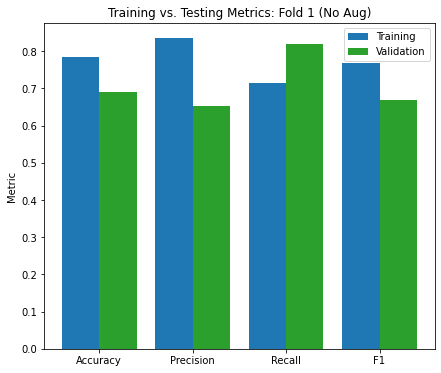

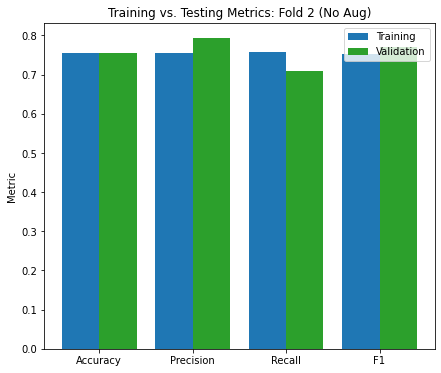

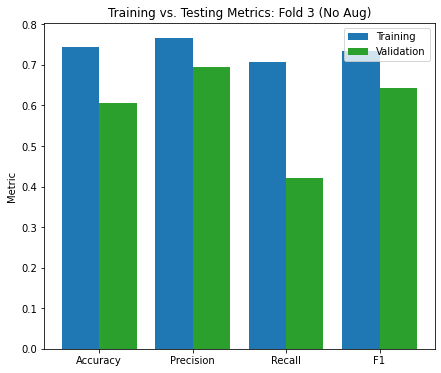

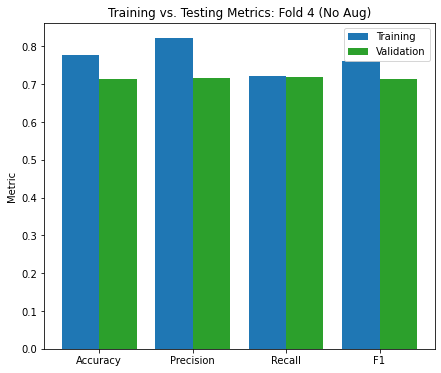

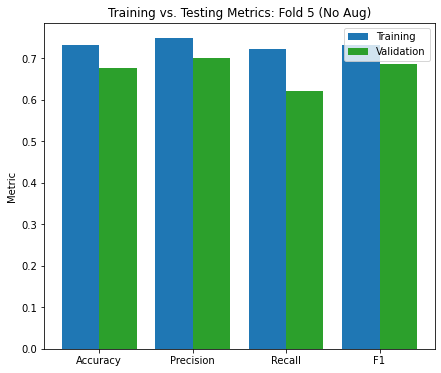

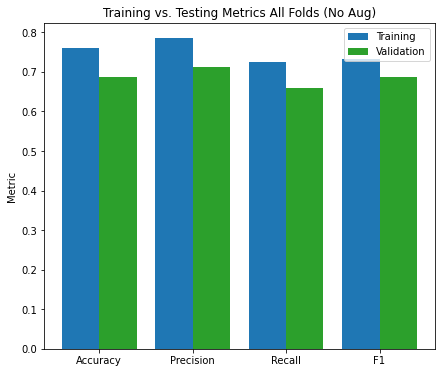

In [47]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}_naug.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all_naug.png")
    plt.show()